In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import re
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [4]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [5]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [6]:
start_dt = '2021-08-01'
end_dt = '2021-08-31'
bug_start_dt = '2021-07-08'
bug_end_dt = '2021-07-11'


1. CPI - CPI factor for campaign, campaign x line

2. Discrepancy with SingleTap GM page - API? rows1 shouldn't have a discrepancy 
- DSP revenue - source? cohorted?

3. Margin 7d 30d

by exchange, ad format, model, campaign, experience

- AutoPilot spend - where is the loss?




In [7]:
df = bigquery_client.query(f"""
select
    r.ssb_buyer_id
    , date
    , extract(date from etimestamp) as edate
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , exchange_id
    , r.imp_type
    , r.ad_type
    , r.ad_size
    , r.deal_id
    , case when r.ctr_model = 'production' or r.cr_model = 'production' then 'AP' else 'ML' end as model
    , sp.bundle as sponsored_bnd
    , ho.bundle as hosting_bnd
    , sp.name as sponsored_bnd_name
    , ho.name as hosting_bnd_name
    , sp.category as sponsored_category
    , ho.category as hosting_category
    , r.os_version_text
    , r.country
    , r.platform
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*16/1000 as bid
from stats.rows1 r
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(r.id,1) = '0'
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
""").to_dataframe()

In [6]:
df_short = bigquery_client.query(f"""
select
    r.ssb_buyer_id
    , date
    , extract(date from etimestamp) as edate
    , c.name as campaign_name
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(case when event_type = 'install' then revenue else 0 end) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
from stats.rows1 r
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
group by 1,2,3,4
""").to_dataframe()

In [9]:
# df_short['media_cost'] = df_short['cost']*1.25
df['media_cost'] = df['cost']*1.25
df['bug'] = np.where((df.date >= pd.to_datetime(bug_start_dt)) & (df.date <= pd.to_datetime(bug_end_dt)), True, False)
df.groupby(['date','bug'])['spend'].sum()

date        bug  
2021-08-01  False    231515.04
2021-08-02  False    227583.68
2021-08-03  False    227263.68
2021-08-04  False    203136.64
2021-08-05  False    201752.80
2021-08-06  False    193496.64
2021-08-07  False    203085.12
2021-08-08  False    206482.08
2021-08-09  False    205347.20
2021-08-10  False    205367.84
2021-08-11  False    198946.88
2021-08-12  False    195604.16
2021-08-13  False    207034.72
2021-08-14  False    216011.36
2021-08-15  False    213557.92
2021-08-16  False    200227.52
2021-08-17  False    194200.80
2021-08-18  False    197492.48
2021-08-19  False    163494.56
2021-08-20  False    175754.24
2021-08-21  False    184466.40
2021-08-22  False    186262.24
2021-08-23  False    169624.80
2021-08-24  False    176164.96
2021-08-25  False    176674.40
2021-08-26  False    190614.40
2021-08-27  False    198926.72
2021-08-28  False    200515.68
2021-08-29  False    207106.56
2021-08-30  False    186376.64
2021-08-31  False    175444.80
Name: spend, dtype: f

In [8]:
df = df.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df = df.set_index('imp_type').join(imp_type.set_index('imp_type_id')).reset_index()

# 1. CPI - CPI factor for campaign, campaign x line

In [13]:
df_campaigns = bigquery_client.query(f"""
select
    *
from metadata.campaigns
""").to_dataframe()
json_struct = df_campaigns['extra_data'].apply(json.loads)
df_campaigns_flat = pd.io.json.json_normalize(json_struct) 
df_campaigns_joined = df_campaigns.join(df_campaigns_flat)
df_campaigns_joined.drop(['extra_data'], axis = 1, inplace = True)
df_campaigns_joined.rename(columns = {'uuid':'ssb_campaign_uuid'}, inplace=True)
df_campaigns_joined.columns[:100]

Index(['name', 'created_at', 'end_at', 'ssb_campaign_uuid', 'country',
       'status', 'vertical_tag', 'form_factor', 'platform', 'enabled',
       'offer_id', 'start_at', 'id', 'sponsored_app_id', 'updated_at',
       'ssb_buyer_id', 'last_enabled_at', 'max_views', 'model_optimize',
       'connectivity', 'click_url', 'maxmind_mask', 'geo_cities_target_type',
       'zipcodes_target_type', 'device_models_target_type',
       'os_vers_target_type', 'maxmind_carrier_codes_target_type',
       'ip_ranges_target_type', 'age_ranges_target_type',
       'carrier_ids_target_type', 'time_of_week_target_type',
       'gender_target_type', 'target_user_lists', 'tags', 'day_of_week',
       'time_fencing', 'geo_cities', 'zipcodes', 'device_models', 'os_vers',
       'maxmind_carrier_codes', 'ip_ranges', 'age_ranges', 'carrier_ids',
       'time_of_week', 'gender', 'admin_only', 'media_plan_daily_budget',
       'last_disabled_at', 'media_scan_settings.max_wins',
       'media_scan_settings.max_

In [14]:
df_campaigns_joined.isna().sum().head(30)

name                                     0
created_at                               0
end_at                               12865
ssb_campaign_uuid                        0
country                                  0
status                                   0
vertical_tag                          4198
form_factor                              0
platform                                 0
enabled                                  0
offer_id                                 0
start_at                             12564
id                                       0
sponsored_app_id                     13866
updated_at                               0
ssb_buyer_id                             0
last_enabled_at                       1972
max_views                              494
model_optimize                         340
connectivity                           224
click_url                            13058
maxmind_mask                           340
geo_cities_target_type                 333
zipcodes_ta

In [15]:
df_offers = bigquery_client.query(f"""
select
    *
from metadata.offers
""").to_dataframe()
json_struct = df_offers['extra_data'].apply(json.loads)
df_offers_flat = pd.io.json.json_normalize(json_struct) 
df_offers_joined = df_offers.join(df_offers_flat)
df_offers_joined.drop(['extra_data'], axis = 1, inplace = True)
df_offers_joined.rename(columns = {'id':'offer_id'},inplace = True)
df_offers_joined.columns[:100]

Index(['package_name', 'user_defined_type', 'type', 'form_factor', 'country',
       'status', 'updated_at', 'ssb_buyer_id', 'affiliate_network', 'cpi',
       'platform', 'name', 'created_at', 'sponsored_app_app_id',
       'unique_offer', 'offer_id', 'click_url', 'landing_url', 'iab_category',
       'store_category', 'vertical_tag', 'publisher', 'extra_advertisers',
       'status_updated_at', 'last_activated_at', 'click_url_redirects',
       'google_product_categories', 'google_sensitive_categories',
       'external_click_url', 'user_defined_optimization_type', 'extra_bcats',
       'target_user_type', 'enable_s2s_click', 'impression_pixel_url',
       'impression_pixel_urls', 'custom_click_url', 'dt_enabled',
       'enable_imp_dedup', 'status_data', 'optimization_action_name',
       'optimization_cpa_goal', 'optimization_action_num_days',
       'auto_pilot_cpi_factor', 'org_landing_url', 'reject_data',
       'geoedge_excluded_trigger_types', 'auto_pilot_cpa_factor',
       '

In [16]:
df_offers_joined.rename(columns = {'id':'offer_id'},inplace = True)

In [17]:
campaign_cols = ['ssb_campaign_uuid','ssb_buyer_id','id','name','vertical_tag','form_factor','offer_id','max_views','auto_pilot','auto_pilot_level'
                ,'use_dlp','block_coppa','show_for_converted','use_external_browser','model_optimize','boost_enabled','boost_max_multiplier',
                'connectivity','maxmind_mask','media_plan_pacing_mode','media_plan_daily_budget','impression_attribution_enabled','override_auto_actions','viewability_mode'
                ,'add_click_on_video_complete','smart_dnt','os_vers_target_type','deals_target_type','device_model_ids_target_type','device_models','device_make'
                ,'os_vers','device_model_ids','device_price_level_ranges','creative_opt_enabled','vta','model_opt_mode','fcap_min_impressions_interval','fcap_consecutive_impressions'
                ,'ifa_presence','auto_pilot_ctr_opt','force_supports_wildcard','ifa_ap_mode','model_push_enabled','min_os_version','auto_pilot_stop_mode'
                ,'mp_daily_installs']

offer_cols = ['offer_id','ssb_buyer_id','package_name','cpi','auto_pilot_cpi_factor','iab_category','store_category','external_click_url','click_url','s2s_click_url','impression_pixel_url','dt_enabled'
               ,'user_defined_optimization_type','enable_s2s_click','enable_imp_dedup']

In [18]:
df_campaigns_offers = df_campaigns_joined[campaign_cols].set_index(['offer_id','ssb_buyer_id']).join(df_offers_joined[offer_cols].set_index(['offer_id','ssb_buyer_id']), lsuffix = '_campaign',rsuffix = '_offer').reset_index()
df_campaigns_offers['device_make']


0         []
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
13907     []
13908     []
13909     []
13910     []
13911     []
Name: device_make, Length: 13912, dtype: object

In [15]:
days_lookback=7
spend_by_campaign = df[(df.bug==False) & (df.date >= (pd.to_datetime(end_dt)-datetime.timedelta(days=days_lookback-1)))].groupby(['ssb_campaign_uuid'])['spend','media_cost','installs'].sum()/(days_lookback)
spend_by_campaign.rename({'spend':'daily_spend','media_cost':'daily_media_cost','installs':'daily_installs'},axis=1, inplace = True)
spend_by_campaign[spend_by_campaign.index=='a60b75e69079fb3b46baf01c061b7a58']


daily_spend  daily_media_cost  \
ssb_campaign_uuid                                                 
a60b75e69079fb3b46baf01c061b7a58  4621.028571       5406.514628   

                                  daily_installs  
ssb_campaign_uuid                                 
a60b75e69079fb3b46baf01c061b7a58     2009.142857

In [16]:
df_campaigns_offers_spend = spend_by_campaign.join(df_campaigns_offers.set_index(['ssb_campaign_uuid'])).reset_index()
df_campaigns_offers_spend['auto_pilot_cpi_factor'] = df_campaigns_offers_spend['auto_pilot_cpi_factor'].fillna(1)
df_campaigns_offers_spend['eDaily_rev_budget'] = df_campaigns_offers_spend.mp_daily_installs * df_campaigns_offers_spend.cpi
df_campaigns_offers_spend['ecpi'] = df_campaigns_offers_spend.daily_media_cost/df_campaigns_offers_spend.daily_installs
df_campaigns_offers_spend['tcpi'] = df_campaigns_offers_spend.cpi * df_campaigns_offers_spend.auto_pilot_cpi_factor

filters = (df_campaigns_offers_spend.ssb_buyer_id == 3549) 
cols = ['name','id','ssb_campaign_uuid','package_name','media_plan_daily_budget','daily_media_cost','cpi','auto_pilot_cpi_factor','tcpi','ecpi','mp_daily_installs','daily_installs','eDaily_rev_budget','daily_spend']
campaign_setup = df_campaigns_offers_spend.loc[filters, cols].sort_values('daily_spend', ascending = False)
lookback_start = (pd.to_datetime(end_dt)-datetime.timedelta(days=days_lookback-1)).strftime('%Y-%m-%d')
campaign_setup.to_csv(f'~/Downloads/campaign_setup_{lookback_start}_{end_dt}.csv')
campaign_setup.head(30).round(2)


name   id  \
229           Position Mobile – Weather Home – US – UA   89   
281          Particle Media - News Break - US - VZW PR   46   
152                         Pandora - Pandora - US - 1  116   
171          Pandora - Pandora - US - 4 -banner/native  226   
459                         Pandora - Pandora - US - 2   80   
126                        Twitter - Twitter - BR - UA  190   
730                   Android-Grupo Coppel-Coppel-MX-2  465   
718             Android-Amply Media-Breaking News-US-2  415   
277             SmartNews_Verizon_SingleTap_All_CPI_NA  173   
411                       Android-Twitter-Twitter-PK-4  481   
160                 SmartNews_ATT_SingleTap_All_CPI_NA  174   
118                         Pandora - Pandora - US - 3  114   
391                       Pandora - Pandora - US - iOS  161   
226                            Weedmaps-Weedmaps-US-UA   92   
597            SmartNews_Tracfone_SingleTap_All_CPI_NA  100   
484          Particle Media - News Break - US - ATT PR   14   
240     Particle Media - News Break - US - Tracfone PR   40   
206         Android-Magazine Luiza-Magazine Luiza-BR-2  518   
207           Android-SmartNews Inc-SmartNews-US-ATT-2  317   
560      Android-SmartNews Inc-SmartNews-US-Tracfone-2  338   
37                Position Mobile - NewsHome - US - UA   12   
183         DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA  201   
31             Android-SmartNews Inc-SmartNews-US-VZ-2  315   
713                       Android-Twitter-Twitter-EG-2  426   
644                       Android-Twitter-Twitter-ID-4  324   
410       Particle Media – News Break – US – All – GP2  172   
657             SmartNews_Cricket_SingleTap_All_CPI_NA   17   
590                         Playsimple-Word Jam-US-RON   26   
254       Android-SmartNews Inc-SmartNews-US-Cricket-2  336   
67   Particle Media – News Break – US – All – GP - ...   77   

                    ssb_campaign_uuid                package_name  \
229  4c7f5d9964abdca5793b3d48f13fe6f9      com.home.weather.radar   
281  60afc4f294695ffe7ea525534f019d20  com.particlenews.newsbreak   
152  30bc823acca34196010b05475c5d77ec         com.pandora.android   
171  377f69bc9e2d613ee60d07d1df5897d5         com.pandora.android   
459  a60b75e69079fb3b46baf01c061b7a58         com.pandora.android   
126  292906bbb71deaebb880439ce8c72995         com.twitter.android   
730  ff5f6bfc2de6ff0dc959dc9300ed4f83        com.coppel.coppelapp   
718  fb9d2fdb882ea110d77ab74ffc35730a   com.breakingnewsbrief.app   
277  5fef83d15c5b811b424ed58aeb82d0a7  jp.gocro.smartnews.android   
411  962d52a1a1605f0086dcff2e9da3cada         com.twitter.android   
160  33bff90d655b976e9399f1d0b0463d22  jp.gocro.smartnews.android   
118  26ae46e908d03fbe20c01f7fd804a788         com.pandora.android   
391  8f6af55d3b890df1566e59c4bcf13d3c                   284035177   
226  4c2507672d44889680be77f2422c91ac    com.weedmaps.app.android   
597  d8be47c87ebd5047c552f92421103f1a  jp.gocro.smartnews.android   
484  b291b1c34d27bb722c2a3cd95748e5f0  com.particlenews.newsbreak   
240  50a1b5ac38354aa6f2b023e8e462c883  com.particlenews.newsbreak   
206  4602e704fb2f737aef26a2ddb7459a66         com.luizalabs.mlapp   
207  460c77fda3ba6cdf651311f5eedb7187  jp.gocro.smartnews.android   
560  d018489d8075c72fa12c6bf0e7f54fbb  jp.gocro.smartnews.android   
37   0c0ded719c3afb709b937d7a19e98991      com.home.news.breaking   
183  3bf043901874bb0ef510dc88b8a764ad      in.playsimple.wordtrip   
31   099a5d47e9bf3796c1b9ca5c5f4bc264  jp.gocro.smartnews.android   
713  fad842726082aa12e048b2e0e8cb8c7a         com.twitter.android   
644  e8fd14220c0331282ea593f073fe10c7         com.twitter.android   
410  95f82f59fd9cac3b272b560f722e35d6  com.particlenews.newsbreak   
657  eb6dbe92b98fe9a91b00eb06ae37070e  jp.gocro.smartnews.android   
590  d68c7b0af30354df7c23485a57b8f17e     in.playsimple.tripcross   
254  545149fc54f7c1283d6c0c90ab8ce7e2  jp.gocro.smartnews.android   
67   16d935fca4ea8b4dffa29

# 2. Discrepancy with SingleTap GM page - API? rows1 shouldn't have a discrepancy

DSP revenue - source? cohorted?

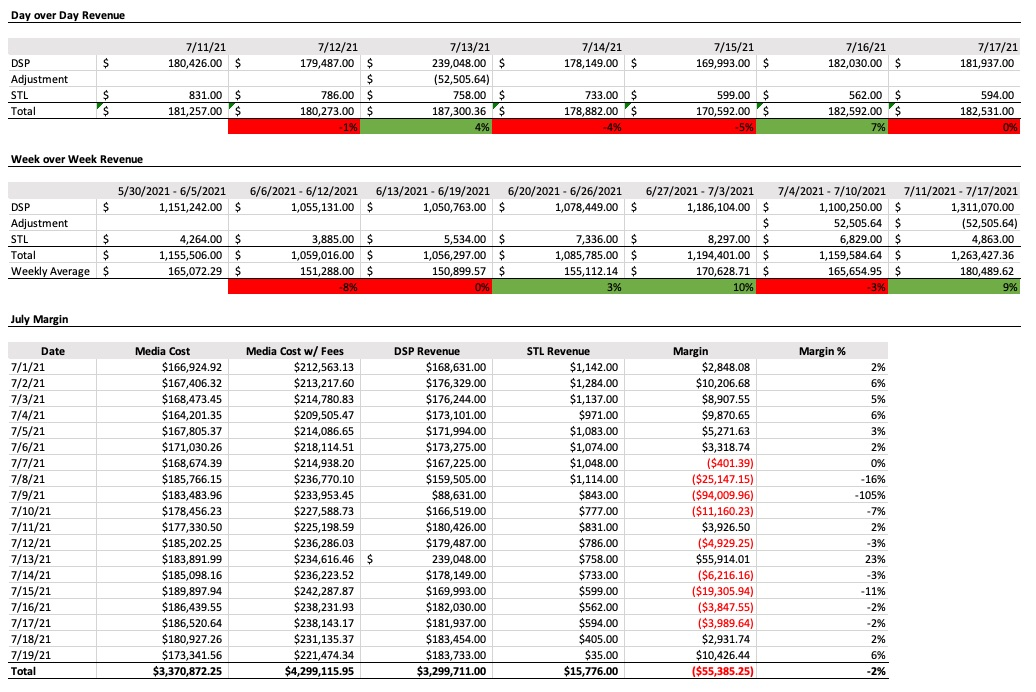

In [17]:
from IPython.display import Image 
Image(filename='files/STI margin.jpeg')

In [18]:
atlas_query = """
select campaign_name, on_date_metrics as "date", country, sum(cost) cost, sum(revenue) spend
from reporting.dt_appreciate_operational_metrics a 
where on_date_metrics >= '{start_dt}'
and on_date_metrics <= '{end_dt}'
group by 1,2,3
"""
cur_atlas.execute(atlas_query.format(start_dt = start_dt, end_dt = end_dt))
atlas_campaign_byday = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [19]:
atlas_campaign_byday.date = pd.to_datetime(atlas_campaign_byday.date)
df_short['date'] = pd.to_datetime(df_short['date'])

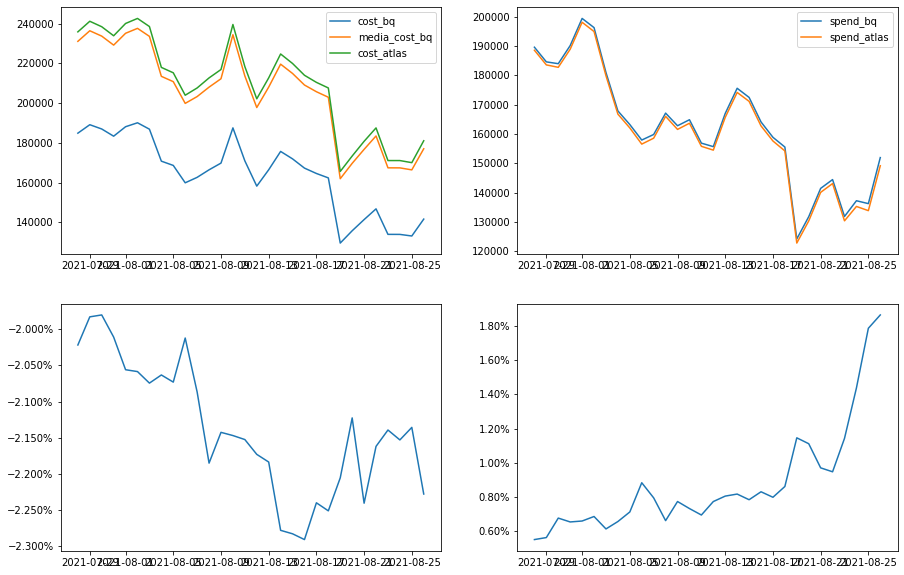

In [20]:
atlas_byday = atlas_campaign_byday.groupby('date')['spend','cost'].sum()
bq_byday = df_short[df_short.ssb_buyer_id == 3549].groupby('date')['spend','cost','media_cost'].sum()
joined_byday = bq_byday.join(atlas_byday, how = 'outer', lsuffix = '_bq', rsuffix = '_atlas')
joined_byday['cost_diff'] = 100*joined_byday['media_cost']/joined_byday['cost_atlas']-100
joined_byday['spend_diff'] = 100*joined_byday['spend_bq']/joined_byday['spend_atlas']-100

fig, ax = plt.subplots(2,2, figsize = (15,10))
ax[0,0].plot(joined_byday[['cost_bq','media_cost','cost_atlas']])
ax[0,0].legend(['cost_bq','media_cost_bq','cost_atlas'])
ax[0,1].plot(joined_byday[['spend_bq','spend_atlas']])
ax[0,1].legend(['spend_bq','spend_atlas'])
ax[1,0].plot(joined_byday[['cost_diff']])
ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1,1].plot(joined_byday[['spend_diff']])
ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))

Within 1% for spend, 2% for media cost. 

In [21]:
cols = ['spend_bq','spend_atlas','spend_diff','media_cost','cost_atlas','cost_diff']
format_map = {'spend_atlas':'${:,.0f}', 'spend_bq':'${:,.0f}', 'cost_atlas':'${:,.0f}', 'media_cost':'${:,.0f}', 'cost_bq':'${:,.0f}', 'spend_diff':'{:,.0f}%', 'cost_diff':'{:,.0f}%'}
joined_byday[cols].style.format(format_map)

In [22]:
joined_total = joined_byday.sum()
joined_total['cost_diff'] = 100*joined_total['media_cost']/joined_total['cost_atlas']-100
joined_total['spend_diff'] = 100*joined_total['spend_bq']/joined_total['spend_atlas']-100
joined_total.to_frame().transpose()[cols].style.format(format_map)

In [23]:
atlas_bycampaign = atlas_campaign_byday.groupby('campaign_name')['spend','cost'].sum().astype(float)
atlas_bycampaign.columns = ['spend_atlas','cost_atlas']
bq_bycampaign = df_short[df_short.ssb_buyer_id == 3549].groupby('campaign_name')['spend','media_cost'].sum()
bq_bycampaign.columns = ['spend_bq','media_cost']
joined_bycampaign = bq_bycampaign.join(atlas_bycampaign, how = 'outer', lsuffix = '_bq', rsuffix = '_atlas')
joined_bycampaign['cost_diff'] = 100*joined_bycampaign['media_cost']/joined_bycampaign['cost_atlas']-100
joined_bycampaign['spend_diff'] = 100*joined_bycampaign['spend_bq']/joined_bycampaign['spend_atlas']-100
joined_bycampaign.sort_values('spend_atlas', ascending = False, inplace = True)
joined_bycampaign.replace([np.inf, -np.inf], np.nan, inplace = True)

joined_bycampaign[cols].head(40).style.format(format_map)


In [24]:
joined_bycampaign.loc[(abs(joined_bycampaign.cost_diff)>10)|(abs(joined_bycampaign.spend_diff)>10),cols].style.format(format_map)

In [25]:
pivot = joined_bycampaign[(joined_bycampaign.index.str.startswith('Pandora - Pandora - US - 4'))].pivot_table(values = ['spend_bq','spend_atlas','media_cost','cost_atlas'], index = 'campaign_name', aggfunc = np.sum)
pivot.loc['Total'] = pivot.sum(axis=0)
pivot.style.format(format_map)

In [26]:
# df_lines = bigquery_client.query(f"""
# select
#     *
# from metadata.lines
# """).to_dataframe()
# json_struct = df_lines['extra_data'].apply(json.loads)
# df_lines_flat = pd.io.json.json_normalize(json_struct) 
# df_lines_joined = df_lines.join(df_lines_flat)
# df_lines_joined.drop(['extra_data'], axis = 1, inplace = True)
# df_lines_joined.rename(columns = {'uuid':'exploration_uuid'}, inplace=True)
# df_lines_joined = df_lines_joined[['exploartion_uuid','bid_price']]
# df_lines_joined.columns[:100]

# 3. Margin 7d 30d - find highs and lows

In [10]:
def calc_metrics(df, sov_base = 0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['media_cost']/df['impressions']
    df['rpi'] = df['spend']/df['installs']
    df['margin'] = 100*(df['spend']-df['media_cost'])/df['spend']

    if sov_base == 0:
        df['media_cost_sov'] = 100*df['media_cost']/df['media_cost'].sum()
        df['spend_sov'] = 100*df['spend']/df['spend'].sum()
    else:
        df['media_cost_sov'] = 100*df['media_cost']/df.groupby(sov_base)['media_cost'].transform(sum)
        df['spend_sov'] = 100*df['spend']/df.groupby(sov_base)['spend'].transform(sum)
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','spend','spend_sov','media_cost','media_cost_sov','margin']]

format_map = {'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'spend':'${:,.0f}'
             ,'media_cost':'${:,.0f}'
             ,'rpi':'${:,.2f}'
             ,'tCPI':'${:,.2f}'
             ,'eCPI':'${:,.2f}'
             ,'cpi':'${:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'spend_sov':'{:,.0f}%'
             ,'auto_pilot_cpi_factor':'{:,.2f}'
             ,'diff_from_tcpi':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'media_cost_sov':'{:,.0f}%'}

In [11]:
df['experience_type'] = df.apply(lambda x:classify_campaigns(x), axis = 1)

In [19]:
df = df.set_index(['ssb_campaign_uuid','ssb_buyer_id']).join(df_campaigns_offers.set_index(['ssb_campaign_uuid','ssb_buyer_id']), rsuffix = '_campaigns').reset_index()


In [20]:
i = 'date'

pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')


In [21]:
i = 'ssb_buyer_id'

pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')


In [22]:
i = 'exchange_name'

pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [23]:
i = ['sponsored_bnd_name']

pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [24]:
i = ['sponsored_bnd_name','experience_type','campaign_name']

pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [25]:
i = ['impression type']
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [26]:
i = ['impression type','ad_type']
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [27]:
i = ['exchange_name','impression type', 'ad_type']
filters = (df.exchange_name.isin(['AppLovin','Fyber','InMobi','MoPub','Unity'])) & (~df.bug)
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [28]:
i = ['impression type','ad_size']
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [29]:
i = ['model']
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [30]:
i = ['model','country']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [31]:
i = ['model','impression type','ad_type']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [32]:
i = ['model','exchange_name']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [33]:
i = ['model','exchange_name','impression type','ad_type']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [34]:
i = ['experience_type','model']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [35]:
i = ['sponsored_bnd_name','campaign_name']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = (df.experience_type == 1) & (df.model == 'AP')
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('media_cost', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [36]:
i = ['model', 'impression type']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0

filters = (~df.bug) & (df.experience_type == 2)
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [37]:
i = ['auto_pilot','model']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [38]:
i = ['model','model_optimize']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values(['model','model_optimize'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [39]:
i = ['campaign_name']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
filters = (~df.bug) & (df.model == 'AP') & (df.model_optimize == 80)
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('media_cost', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

What are these??


In [40]:
i = ['exchange_name']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
filters = (~df.bug) & (df.model == 'AP') & (df.model_optimize == 80)
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('media_cost', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [41]:
i = ['ssb_buyer_id']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
filters = (~df.bug) & (df.model == 'AP') & (df.model_optimize == 80)
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('media_cost', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

must be some special arrangement with MW

In [42]:
i = ['model','model_opt_mode','model_optimize']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values(['model','model_opt_mode','model_optimize'], ascending = False, inplace = True)
format_pivot[format_pivot.media_cost_sov>.1].style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [43]:
i = ['campaign_name']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
filters = (~df.bug) & (df.model == 'AP') & (df.model_opt_mode == 1) & (df.model_optimize == 30)
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('media_cost', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

a lot of these look like they are retargeting campaigns (special billing), or experience 4 campaigns that are underperforming

In [44]:
i = ['model','auto_pilot_cpi_factor']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot[format_pivot.media_cost_sov>.01].head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [45]:
i = ['model','impression type','ad_size']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values(['model','spend'], ascending = [True, False], inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [46]:
i = ['model','exchange_name']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values(['model','spend'], ascending = [True, False], inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [47]:
i = ['model','sponsored_bnd']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values(['model','spend'], ascending = [True, False], inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [48]:
i = ['model','campaign_name','impression type','ad_type']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[(~df.bug) & (df.model == 'AP')].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values(['model','media_cost'], ascending = [True, False], inplace = True)
format_pivot[format_pivot.media_cost_sov>.11].style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [49]:
i = ['hosting_category']
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [50]:
i = ['platform']
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [51]:
i = ['sponsored_category']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [52]:
i = ['country']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [53]:
i = ['experience_type']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [54]:
i = ['experience_type','sponsored_bnd_name']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [55]:
i = ['vertical_tag']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [56]:
i = ['form_factor']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [57]:
i = ['max_views']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [58]:
i = ['auto_pilot','auto_pilot_level']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [59]:
i = ['use_dlp']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [60]:
i = ['block_coppa']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [61]:
i = ['show_for_converted']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [62]:
i = ['use_external_browser']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [63]:
i = ['model_optimize']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [64]:
i = ['boost_enabled','boost_max_multiplier']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [65]:
i = ['connectivity']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [66]:
i = ['maxmind_mask']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [67]:
i = ['media_plan_pacing_mode']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [68]:
i = ['impression_attribution_enabled']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [69]:
i = ['override_auto_actions']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [70]:
i = ['viewability_mode']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [71]:
i = ['add_click_on_video_complete']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [72]:
i = ['smart_dnt']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [73]:
i = ['platform','os_vers_target_type']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [74]:
i = ['creative_opt_enabled']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [75]:
i = ['vta']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [76]:
i = ['model_opt_mode']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [77]:
i = ['fcap_min_impressions_interval']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [78]:
i = ['fcap_consecutive_impressions']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [79]:
i = ['ifa_presence']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [80]:
i = ['auto_pilot_ctr_opt']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [81]:
i = ['force_supports_wildcard']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [82]:
i = ['ifa_ap_mode']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [83]:
i = ['model_push_enabled']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [109]:
i = ['min_os_version']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [85]:
i = ['auto_pilot_stop_mode']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [86]:
i = ['auto_pilot_cpi_factor']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[(~df.bug)].fillna(-1).pivot_table(values = ['ssb_campaign_uuid','impressions','clicks','installs','spend','media_cost'], index = i, 
                                             aggfunc = {'impressions':np.sum,
                                                       'clicks':np.sum,
                                                       'installs':np.sum,
                                                       'spend':np.sum,
                                                       'media_cost':np.sum,
                                                       'ssb_campaign_uuid':lambda x:len(x.unique())})
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']
pivot['cpm'] = 1000*pivot['media_cost']/pivot['impressions']
pivot['rpi'] = pivot['spend']/pivot['installs']
pivot['margin'] = 100*(pivot['spend']-pivot['media_cost'])/pivot['spend']

pivot['media_cost_sov'] = 100*pivot['media_cost']/pivot['media_cost'].sum()
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].sum()

pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# pivot.sort_values('spend', ascending = False, inplace = True)
cols = ['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','spend','spend_sov','media_cost','media_cost_sov','margin']
pivot.loc[pivot.media_cost_sov>1, cols].style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

# looking into tCPI vs. eCPI, CPI factors, efficacy and cost

In [87]:
filters = (df.date >= pd.to_datetime(end_dt)-datetime.timedelta(days=7))
pivot = df[filters].pivot_table(values = ['cpi','auto_pilot_cpi_factor','media_cost','installs','spend'], index = ['campaign_name','ssb_campaign_uuid'], 
                                aggfunc = {'cpi':np.mean,'auto_pilot_cpi_factor':np.mean,
                                          'media_cost':sum,'installs':sum,'spend':sum})
pivot['auto_pilot_cpi_factor'] = pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['margin'] = 100*(pivot.spend-pivot.media_cost)/pivot.spend
pivot['tCPI'] = pivot['cpi']*pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['eCPI'] = pivot['media_cost']/pivot['installs']
pivot['diff_from_tcpi'] = 100*(pivot.eCPI/pivot.tCPI) - 100
pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
pivot.sort_values('media_cost', ascending = False, inplace = True)
pivot.head(30).style.format(format_map).background_gradient(cmap = cm, subset = ['auto_pilot_cpi_factor','margin','diff_from_tcpi'])


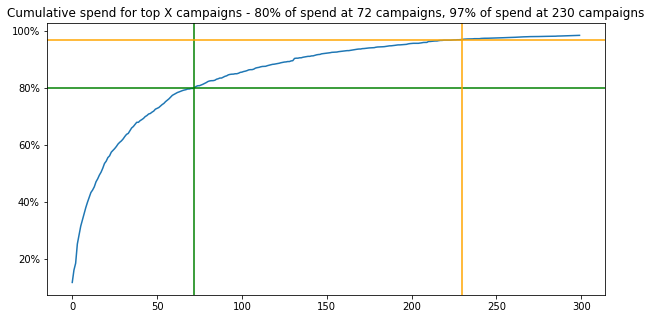

In [88]:
pivot['cum_spend_sov'] = 100*pivot['spend'].cumsum()/pivot['spend'].sum()
top_campaign_ct = (pivot.reset_index().loc[pivot.reset_index().cum_spend_sov > 80]).index.min()
all_campaign_ct = (pivot.reset_index().loc[pivot.reset_index().cum_spend_sov > 97]).index.min()

plt.figure(figsize = (10,5))
plt.plot(pivot.reset_index().iloc[:300].loc[:,'cum_spend_sov'])
plt.title(f'Cumulative spend for top X campaigns - 80% of spend at {top_campaign_ct} campaigns, 97% of spend at {all_campaign_ct} campaigns')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.axvline(x=top_campaign_ct, color = 'green')
plt.axhline(y=80, color = 'green')
plt.axvline(x=all_campaign_ct, color = 'orange')
plt.axhline(y=97, color = 'orange')

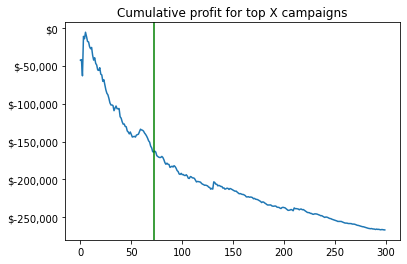

In [89]:
pivot['cum_profit'] = (pivot.spend.cumsum() - pivot.media_cost.cumsum())#/pivot.spend.cumsum()
plt.plot(pivot.reset_index().iloc[:300].loc[:,'cum_profit'])
plt.title('Cumulative profit for top X campaigns')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.axvline(x=top_campaign_ct, color = 'green')

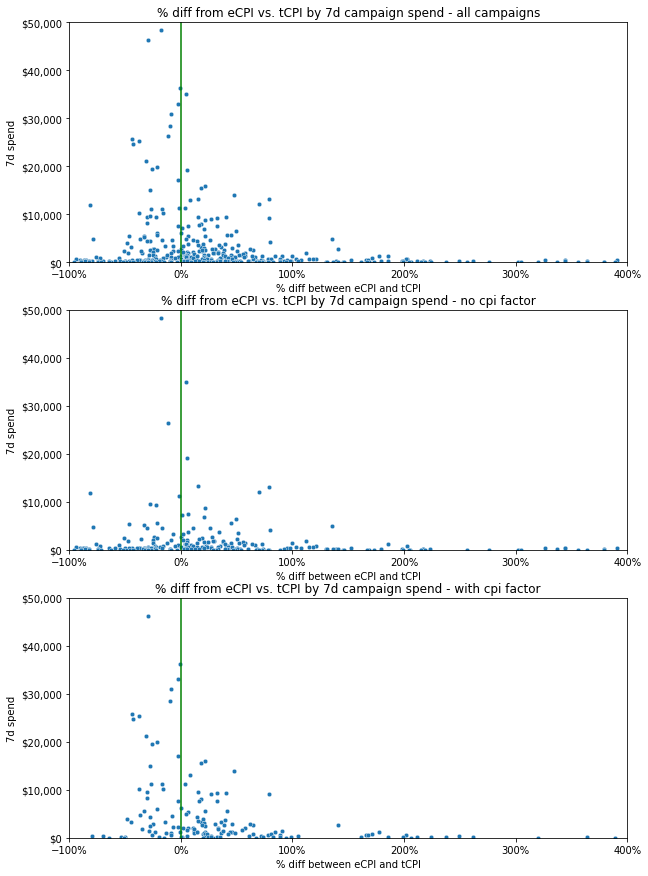

In [90]:
fig, ax = plt.subplots(3,1, figsize = (10,15))

sns.scatterplot(x = 'diff_from_tcpi', y = 'spend', data = pivot, s = 20, ax = ax[0])
ax[0].set_title('% diff from eCPI vs. tCPI by 7d campaign spend - all campaigns')
ax[0].set_ylim(0,50000)
ax[0].set_ylabel('7d spend')
ax[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[0].set_xlim(-100,400)
ax[0].set_xlabel('% diff between eCPI and tCPI')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].axvline(x=0, color = 'green')

sns.scatterplot(x = 'diff_from_tcpi', y = 'spend', data = pivot[pivot.auto_pilot_cpi_factor == 1], s = 20, ax = ax[1])
ax[1].set_title('% diff from eCPI vs. tCPI by 7d campaign spend - no cpi factor')
ax[1].set_ylim(0,50000)
ax[1].set_ylabel('7d spend')
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].set_xlim(-100,400)
ax[1].set_xlabel('% diff between eCPI and tCPI')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1].axvline(x=0, color = 'green')

sns.scatterplot(x = 'diff_from_tcpi', y = 'spend', data = pivot[pivot.auto_pilot_cpi_factor != 1], s = 20, ax = ax[2])
ax[2].set_title('% diff from eCPI vs. tCPI by 7d campaign spend - with cpi factor')
ax[2].set_ylim(0,50000)
ax[2].set_ylabel('7d spend')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_xlim(-100,400)
ax[2].set_xlabel('% diff between eCPI and tCPI')
ax[2].xaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].axvline(x=0, color = 'green')
# break out by tCPI factor vs. if not

Looks like the eCPI converges on target CPI as the media cost gets higher.

The additional factor is that rates/bid factors can get set on the line level. 

In [91]:
interval = 0.2
bins = np.arange(0,3,interval)
labels = np.arange(0+interval,3,interval).round(2)
pivot['cpi_factor_bin'] = pd.cut(pivot.auto_pilot_cpi_factor.fillna(1), bins = bins, labels = labels)


In [92]:
pivot['auto_pilot_cpi_factor'] = pivot['auto_pilot_cpi_factor'].round(2)
pivot2 = pivot.head(all_campaign_ct).reset_index().pivot_table(values = ['ssb_campaign_uuid','spend','media_cost'], index = 'auto_pilot_cpi_factor', aggfunc = {'ssb_campaign_uuid':lambda x:len(x.unique()),'spend':sum,'media_cost':sum}, margins = True)
pivot2['campaign_sov'] = 100*pivot2['ssb_campaign_uuid']/pivot2.loc['All','ssb_campaign_uuid']
pivot2['media_cost_sov'] = 100*pivot2['media_cost']/pivot2.loc['All','media_cost']
pivot2['spend_sov'] = 100*pivot2['spend']/pivot2.loc['All','spend']
pivot2.sort_values('ssb_campaign_uuid', ascending = False, inplace = True)
pivot2[['media_cost_sov','spend_sov','ssb_campaign_uuid','campaign_sov']].iloc[1:21].style.format('{:,.0f}%').format({'ssb_campaign_uuid':'{:,.0f}'})

Text(0.5, 1.0, 'Margin distributions per CPI factor for top 230 campaigns)')

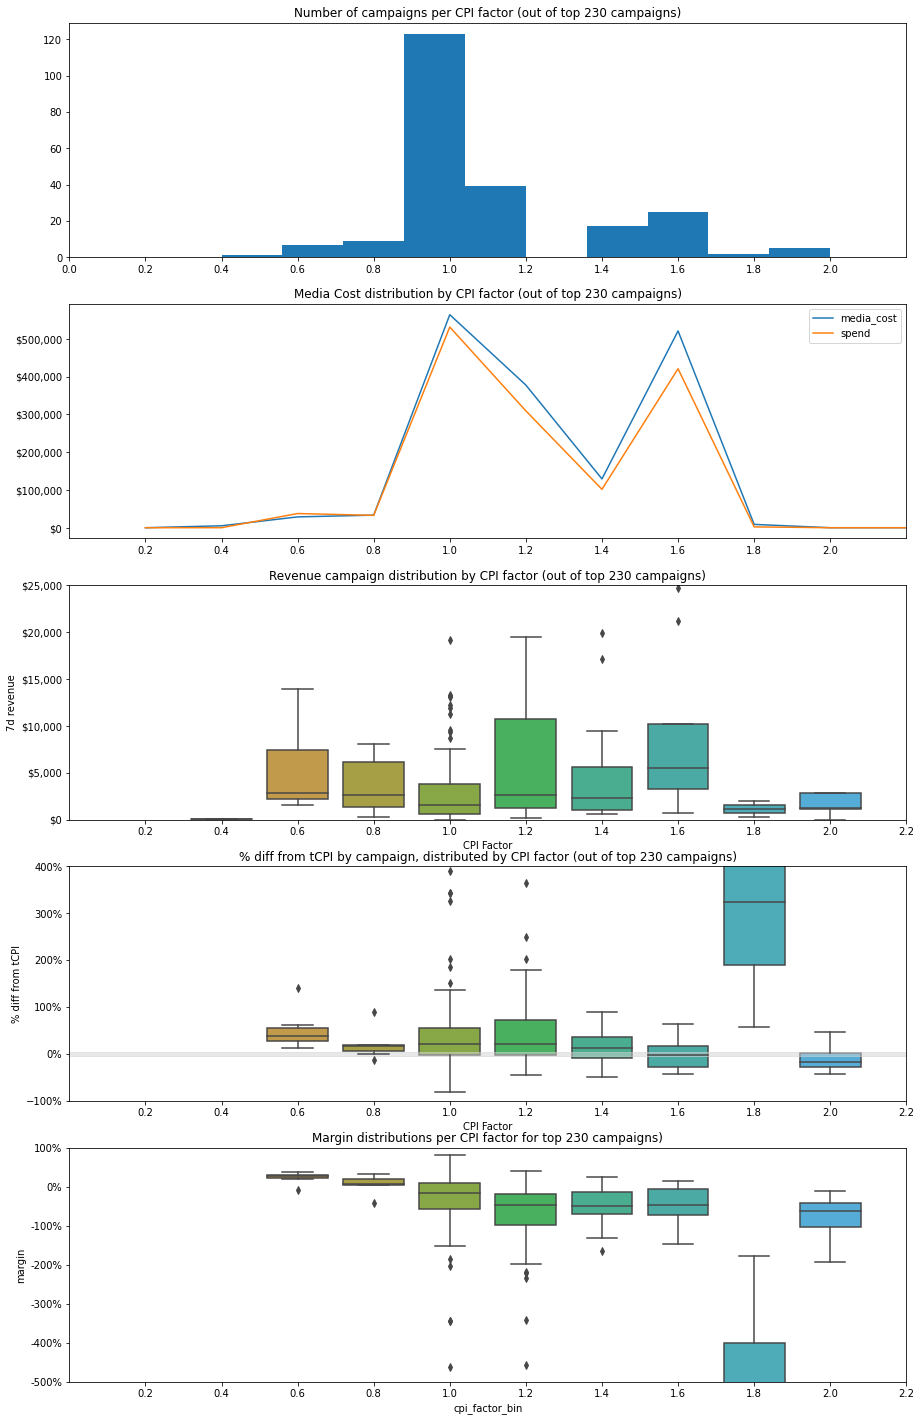

In [93]:
interval = .2
bins = np.arange(0,3,interval)
labels = np.arange(0+interval,3,interval).round(2)
pivot['cpi_factor_bin'] = pd.cut(pivot.auto_pilot_cpi_factor.fillna(1), bins = bins, labels = labels)

by_cpi_factor_bin = pivot.head(all_campaign_ct).loc[pivot.cpi_factor_bin<2].groupby('cpi_factor_bin')['media_cost','spend'].sum()

fig, ax = plt.subplots(5,1,figsize = (15,25))
ax[0].hist(pivot.head(all_campaign_ct).cpi_factor_bin)
ax[0].set_xlim(0,2+interval)
ax[0].set_xticks(np.arange(0,2+interval, interval))
ax[0].set_title(f'Number of campaigns per CPI factor (out of top {all_campaign_ct} campaigns)')
ax[1].plot(by_cpi_factor_bin[['media_cost','spend']])
ax[1].legend(['media_cost','spend'])
ax[1].set_xticks(range(0,10))
ax[1].xaxis.set_ticklabels(np.arange(interval,2+interval,interval).round(1))
ax[1].set_xlim(-1,10)
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].set_title(f'Media Cost distribution by CPI factor (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = 'cpi_factor_bin', y = 'spend', data = pivot.head(all_campaign_ct), ax = ax[2])
ax[2].set_ylim(0,25000)
ax[2].set_ylabel('7d revenue')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_xlim(-1,10)
ax[2].set_xlabel('CPI Factor')
ax[2].set_title(f'Revenue campaign distribution by CPI factor (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = 'cpi_factor_bin', y = 'diff_from_tcpi', data = pivot.head(all_campaign_ct), ax = ax[3])
ax[3].set_ylim(-100,400)
ax[3].set_ylabel('% diff from tCPI')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].set_xlim(-1,10)
ax[3].set_xlabel('CPI Factor')
ax[3].set_title(f'% diff from tCPI by campaign, distributed by CPI factor (out of top {all_campaign_ct} campaigns)')
ax[3].axhspan(-5,5, color = 'lightgrey', alpha = .5)
sns.boxplot(x = 'cpi_factor_bin', y = 'margin', data = pivot.head(all_campaign_ct), ax = ax[4])
ax[4].set_ylim(-500,100)
ax[4].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}%'))
ax[4].set_xlim(-1,10)
ax[4].set_title(f'Margin distributions per CPI factor for top {all_campaign_ct} campaigns)')
# plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(100))
# add revenue on graph 2 

In [94]:
by_cpi_factor_bin['spend_sov'] = 100*by_cpi_factor_bin['spend']/by_cpi_factor_bin['spend'].sum()
by_cpi_factor_bin['media_cost_sov'] = 100*by_cpi_factor_bin['media_cost']/by_cpi_factor_bin['media_cost'].sum()
by_cpi_factor_bin

media_cost      spend  spend_sov  media_cost_sov
cpi_factor_bin                                                     
0.2                  0.000000       0.00   0.000000        0.000000
0.4               5115.150549      64.00   0.004460        0.306950
0.6              28639.781196   37522.40   2.615095        1.718614
0.8              33270.909712   32717.44   2.280217        1.996518
1.0             563504.496693  530925.60  37.002450       33.814731
1.2             377380.438198  309135.20  21.544939       22.645814
1.4             129142.103668  101577.60   7.079372        7.749549
1.6             520561.685323  420632.80  29.315679       31.237822
1.8               8832.214455    2264.00   0.157788        0.530003
2.0                  0.000000       0.00   0.000000        0.000000
2.2                  0.000000       0.00   0.000000        0.000000
2.4                  0.000000       0.00   0.000000        0.000000
2.6                  0.000000       0.00   0.000000        0.000000
2.8                  0.000000       0.00   0.000000        0.000000

Text(0.5, 1.0, 'Margin distributions per CPI factor for top 72 campaigns)')

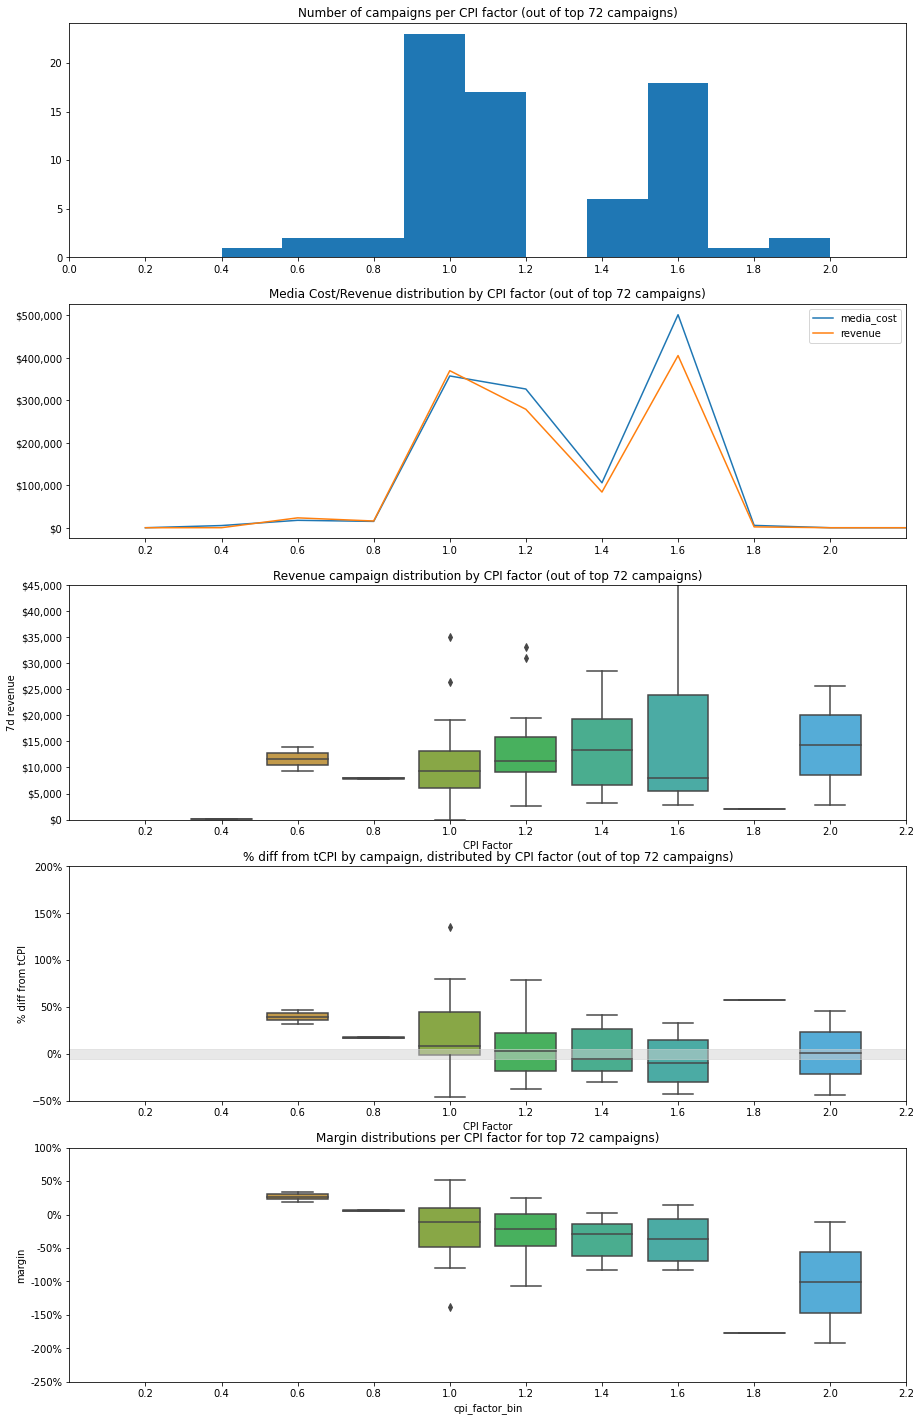

In [95]:
interval = .2
bins = np.arange(0,3,interval)
labels = np.arange(0+interval,3,interval).round(2)
pivot['cpi_factor_bin'] = pd.cut(pivot.auto_pilot_cpi_factor.fillna(1), bins = bins, labels = labels)

by_cpi_factor_bin = pivot.head(top_campaign_ct).loc[pivot.cpi_factor_bin<2].groupby('cpi_factor_bin')['media_cost','spend'].sum()

fig, ax = plt.subplots(5,1,figsize = (15,25))
ax[0].hist(pivot.head(top_campaign_ct).cpi_factor_bin)
ax[0].set_xlim(0,2+interval)
ax[0].set_xticks(np.arange(0,2+interval, interval))
ax[0].set_title(f'Number of campaigns per CPI factor (out of top {top_campaign_ct} campaigns)')
ax[1].plot(by_cpi_factor_bin)
ax[1].legend(['media_cost','revenue'])
ax[1].set_xticks(range(0,10))
ax[1].xaxis.set_ticklabels(np.arange(interval,2+interval,interval).round(1))
ax[1].set_xlim(-1,10)
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].set_title(f'Media Cost/Revenue distribution by CPI factor (out of top {top_campaign_ct} campaigns)')
sns.boxplot(x = 'cpi_factor_bin', y = 'spend', data = pivot.head(top_campaign_ct), ax = ax[2])
ax[2].set_ylim(0,45000)
ax[2].set_ylabel('7d revenue')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_xlim(-1,10)
ax[2].set_xlabel('CPI Factor')
ax[2].set_title(f'Revenue campaign distribution by CPI factor (out of top {top_campaign_ct} campaigns)')
sns.boxplot(x = 'cpi_factor_bin', y = 'diff_from_tcpi', data = pivot.head(top_campaign_ct), ax = ax[3])
ax[3].set_ylim(-50,200)
ax[3].set_ylabel('% diff from tCPI')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].set_xlim(-1,10)
ax[3].set_xlabel('CPI Factor')
ax[3].set_title(f'% diff from tCPI by campaign, distributed by CPI factor (out of top {top_campaign_ct} campaigns)')
ax[3].axhspan(-5,5, color = 'lightgrey', alpha = .5)
sns.boxplot(x = 'cpi_factor_bin', y = 'margin', data = pivot.head(top_campaign_ct), ax = ax[4])
ax[4].set_ylim(-250,100)
ax[4].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}%'))
ax[4].set_xlim(-1,10)
ax[4].set_title(f'Margin distributions per CPI factor for top {top_campaign_ct} campaigns)')
# plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(100))
# add revenue on graph 2 

Text(0.5, 1.0, 'Margin distributions per CPI factor for top 72 campaigns)')

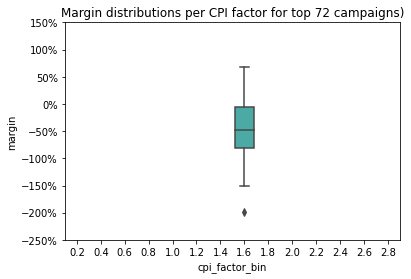

In [96]:
fig, ax = plt.subplots(1,1)
sns.boxplot(x = 'cpi_factor_bin', y = 'margin', data = pivot.loc[pivot.cpi_factor_bin == 1.6], ax = ax)
ax.set_ylim(-250,150)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
# ax.set_xlim(-1,10)
ax.set_title(f'Margin distributions per CPI factor for top {top_campaign_ct} campaigns)')

Looks like at higher CPI factors, the bidder is more able to hit the target. at lower CPI factors, we cannot get the eCPI down enough.

In [97]:
interval = .2
bins = np.arange(0,5+interval,interval)
labels = np.arange(0+interval,5+interval,interval).round(2)
pivot['tCPI_bin'] = pd.cut(pivot.auto_pilot_cpi_factor.fillna(1), bins = bins, labels = labels)

by_tCPI_bin = pivot.head(top_campaign_ct).groupby('tCPI_bin')['media_cost','spend'].sum()
by_tCPI_bin

media_cost     spend
tCPI_bin                         
0.2            0.000000       0.0
0.4         5115.150549      64.0
0.6        17432.701007   23216.0
0.8        14897.523249   15828.0
1.0       357076.786275  369473.6
1.2       326328.944402  278612.0
1.4       105686.205021   83924.8
1.6       501137.212307  405044.0
1.8         5460.740918    1976.0
2.0        36867.388038   28592.0
2.2            0.000000       0.0
2.4            0.000000       0.0
2.6            0.000000       0.0
2.8            0.000000       0.0
3.0            0.000000       0.0
3.2            0.000000       0.0
3.4            0.000000       0.0
3.6            0.000000       0.0
3.8            0.000000       0.0
4.0            0.000000       0.0
4.2            0.000000       0.0
4.4            0.000000       0.0
4.6            0.000000       0.0
4.8            0.000000       0.0
5.0            0.000000       0.0

Text(0.5, 1.0, 'Margin distributions per tCPI for top 72 campaigns)')

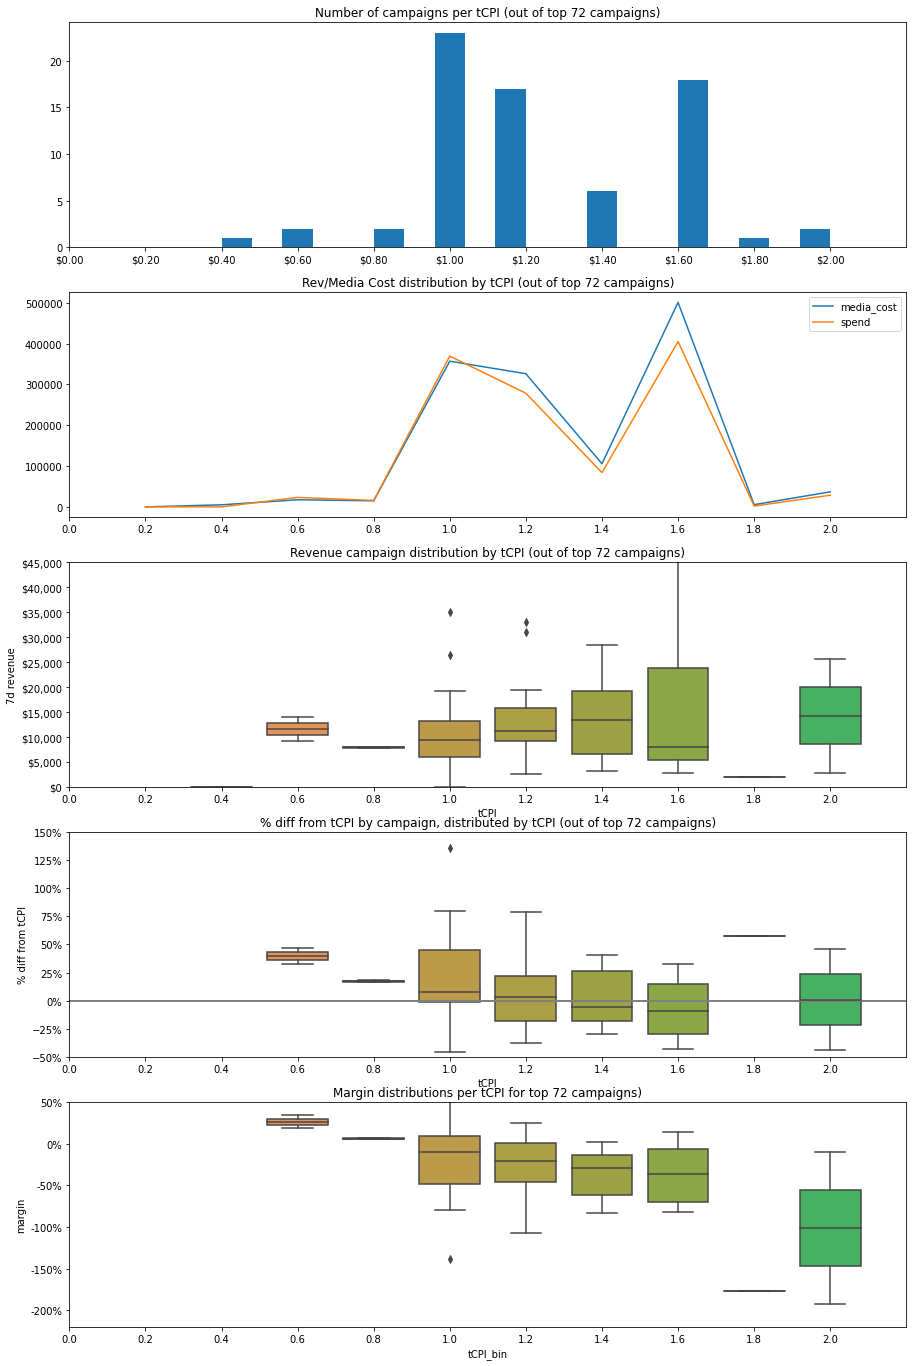

In [98]:
fig, ax = plt.subplots(5,1,figsize = (15,24))
ax[0].hist(pivot.head(top_campaign_ct).tCPI_bin, bins = 20)
ax[0].set_xlim(0,2+interval)
ax[0].set_xticks(np.arange(0,2+interval, interval))
ax[0].xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))
ax[0].set_title(f'Number of campaigns per tCPI (out of top {top_campaign_ct} campaigns)')
ax[1].plot(by_tCPI_bin.loc[by_tCPI_bin.index<=2])
ax[1].legend(['media_cost','spend'])
ax[1].set_xticks(range(-1,10))
ax[1].set_xlim(-1,10)
ax[1].xaxis.set_ticklabels(np.arange(0,2+interval,interval).round(2))
ax[1].set_title(f'Rev/Media Cost distribution by tCPI (out of top {top_campaign_ct} campaigns)')
sns.boxplot(x = 'tCPI_bin', y = 'spend', data = pivot.head(top_campaign_ct), ax = ax[2])
ax[2].set_ylim(0,45000)
ax[2].set_ylabel('7d revenue')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_xticks(range(-1,10))
ax[2].set_xlim(-1,10)
ax[2].xaxis.set_ticklabels(np.arange(0,2+interval,interval).round(2))
ax[2].set_xlabel('tCPI')
ax[2].set_title(f'Revenue campaign distribution by tCPI (out of top {top_campaign_ct} campaigns)')
sns.boxplot(x = 'tCPI_bin', y = 'diff_from_tcpi', data = pivot.head(top_campaign_ct), ax = ax[3])
ax[3].set_ylim(-50,150)
ax[3].set_ylabel('% diff from tCPI')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].set_xticks(range(-1,10))
ax[3].set_xlim(-1,10)
ax[3].set_xlabel('tCPI')
ax[3].xaxis.set_ticklabels(np.arange(0,2+interval,interval).round(2))
ax[3].set_title(f'% diff from tCPI by campaign, distributed by tCPI (out of top {top_campaign_ct} campaigns)')
ax[3].axhline(y = 0, color = 'grey', linewidth = 2)
sns.boxplot(x = 'tCPI_bin', y = 'margin', data = pivot.head(top_campaign_ct), ax = ax[4])
ax[4].set_ylim(-220,50)
ax[4].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}%'))
ax[4].set_xticks(range(-1,10))
ax[4].set_xlim(-1,10)
ax[4].xaxis.set_ticklabels(np.arange(0,2+interval,interval).round(2))
ax[4].set_title(f'Margin distributions per tCPI for top {top_campaign_ct} campaigns)')

It seems that lower cpi factors are higher margin, and higher cpi factors are lower margin. However, the number of campaigns that have non-neutral CPI factors is low (~30%), but these campaigns make up a lot of the spend.

# searching through params to compare eCPI to tCPI diff distributions

In [99]:
all_campaign_list = df.groupby('ssb_campaign_uuid')['spend'].sum().sort_values(ascending = False)[:all_campaign_ct].index.tolist()
all_campaign_list

['4c7f5d9964abdca5793b3d48f13fe6f9',
 '60afc4f294695ffe7ea525534f019d20',
 '292906bbb71deaebb880439ce8c72995',
 'a60b75e69079fb3b46baf01c061b7a58',
 '30bc823acca34196010b05475c5d77ec',
 '377f69bc9e2d613ee60d07d1df5897d5',
 'ff5f6bfc2de6ff0dc959dc9300ed4f83',
 '460c77fda3ba6cdf651311f5eedb7187',
 '5fef83d15c5b811b424ed58aeb82d0a7',
 '26ae46e908d03fbe20c01f7fd804a788',
 'cd0efbabf9eb8408f17f78d551a304ea',
 '33bff90d655b976e9399f1d0b0463d22',
 '8f6af55d3b890df1566e59c4bcf13d3c',
 'd8be47c87ebd5047c552f92421103f1a',
 '962d52a1a1605f0086dcff2e9da3cada',
 '0c0ded719c3afb709b937d7a19e98991',
 'd018489d8075c72fa12c6bf0e7f54fbb',
 'c5534bbfcb4dccdd122f22da877a6f78',
 '50a1b5ac38354aa6f2b023e8e462c883',
 '3bf043901874bb0ef510dc88b8a764ad',
 'e8fd14220c0331282ea593f073fe10c7',
 '95f82f59fd9cac3b272b560f722e35d6',
 '01a919f4b50fe723e51d51b0c2d2509a',
 'b291b1c34d27bb722c2a3cd95748e5f0',
 'fb9d2fdb882ea110d77ab74ffc35730a',
 '099a5d47e9bf3796c1b9ca5c5f4bc264',
 '2dd2a824567d92d80db998336d8c43d6',
 

In [100]:
filters = (df.date >= pd.to_datetime(end_dt)-datetime.timedelta(days=7)) & (df.ssb_campaign_uuid.isin(all_campaign_list))
i = ['impression type']
pivot = df[filters].pivot_table(values = ['cpi','auto_pilot_cpi_factor','media_cost','installs','spend'], index = i+['campaign_name','ssb_campaign_uuid'], 
                                aggfunc = {'cpi':np.mean,'auto_pilot_cpi_factor':np.mean,
                                          'media_cost':sum,'installs':sum,'spend':sum})
pivot['auto_pilot_cpi_factor'] = pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['margin'] = 100*(pivot.spend-pivot.media_cost)/pivot.spend
pivot['tCPI'] = pivot['cpi']*pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['eCPI'] = pivot['media_cost']/pivot['installs']
pivot['diff_from_tcpi'] = 100*(pivot.eCPI/pivot.tCPI) - 100
pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
pivot.sort_values('media_cost', ascending = False, inplace = True)
pivot.reset_index(inplace = True)
pivot.head(30)

impression type                                   campaign_name  \
0          display        Position Mobile – Weather Home – US – UA   
1            video        Position Mobile – Weather Home – US – UA   
2          display       Pandora - Pandora - US - 4 -banner/native   
3            video       Particle Media - News Break - US - VZW PR   
4          display                     Twitter - Twitter - BR - UA   
5            video                Android-Grupo Coppel-Coppel-MX-2   
6            video                    Android-Twitter-Twitter-PK-4   
7          display                          FR Mobijeux IOS BT ALL   
8            video                     Twitter - Twitter - BR - UA   
9            video          Android-Amply Media-Breaking News-US-2   
10         display                      Pandora - Pandora - US - 1   
11         display       Particle Media - News Break - US - VZW PR   
12         display                    Pandora - Pandora - US - iOS   
13         display                      Pandora - Pandora - US - 2   
14  rewarded video        Position Mobile – Weather Home – US – UA   
15         display      DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA   
16           video      DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA   
17          native       Pandora - Pandora - US - 4 -banner/native   
18         display         SmartNews_Tracfone_SingleTap_All_CPI_NA   
19           video         Android-SmartNews Inc-SmartNews-US-VZ-2   
20         display  Particle Media - News Break - US - Tracfone PR   
21           video      Android-Magazine Luiza-Magazine Luiza-BR-2   
22         display                Android-Grupo Coppel-Coppel-MX-2   
23  rewarded video                Android-Grupo Coppel-Coppel-MX-2   
24           video                      Pandora - Pandora - US - 2   
25         display          SmartNews_Verizon_SingleTap_All_CPI_NA   
26         display   Android-SmartNews Inc-SmartNews-US-Tracfone-2   
27           video                    Android-Twitter-Twitter-ID-4   
28           video                                   Onnect_US_DRD   
29         display          Android-Amply Media-Breaking News-US-2   

                   ssb_campaign_uuid  auto_pilot_cpi_factor    cpi  installs  \
0   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     75536   
1   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     29104   
2   377f69bc9e2d613ee60d07d1df5897d5                   1.50   3.00     10592   
3   60afc4f294695ffe7ea525534f019d20                   1.20   3.60      8528   
4   292906bbb71deaebb880439ce8c72995                   1.50   1.00     18176   
5   ff5f6bfc2de6ff0dc959dc9300ed4f83                   0.90   0.50     97264   
6   962d52a1a1605f0086dcff2e9da3cada                   1.20   3.00      7184   
7   cd0efbabf9eb8408f17f78d551a304ea                   1.00  22.00      1200   
8   292906bbb71deaebb880439ce8c72995                   1.50   1.00     14208   
9   fb9d2fdb882ea110d77ab74ffc35730a                   1.00   0.75     28960   
10  30bc823acca34196010b05475c5d77ec                   1.00   2.30     10112   
11  60afc4f294695ffe7ea525534f019d20                   1.20   3.60      5712   
12  8f6af55d3b890df1566e59c4bcf13d3c                   1.40   5.50      3008   
13  a60b75e69079fb3b46baf01c061b7a58                   1.20   2.30      6384   
14  4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     10064   
15  3bf043901874bb0ef510dc88b8a764ad                   1.30   1.80      7856   
16  3bf043901874bb0ef510dc88b8a764ad                   1.30   1.80      7808   
17  377f69bc9e2d613ee60d07d1df5897d5                   1.50   3.00      4880   
18  d8be47c87ebd5047c552f92421103f1a                   1.50   1.70      7440   
19  099a5d47e9bf3796c1b9ca5c5f4bc264                   1.00   1.70      4208   
20  50a1b5ac38354aa6f2b023e8e462c883                   1.40   1.20      7248   
21  4602e704fb2f737aef26a2ddb7459a66                   1.85   0.44     2

Text(0.5, 1.0, 'Margin distributions per impression type for top 230 campaigns)')

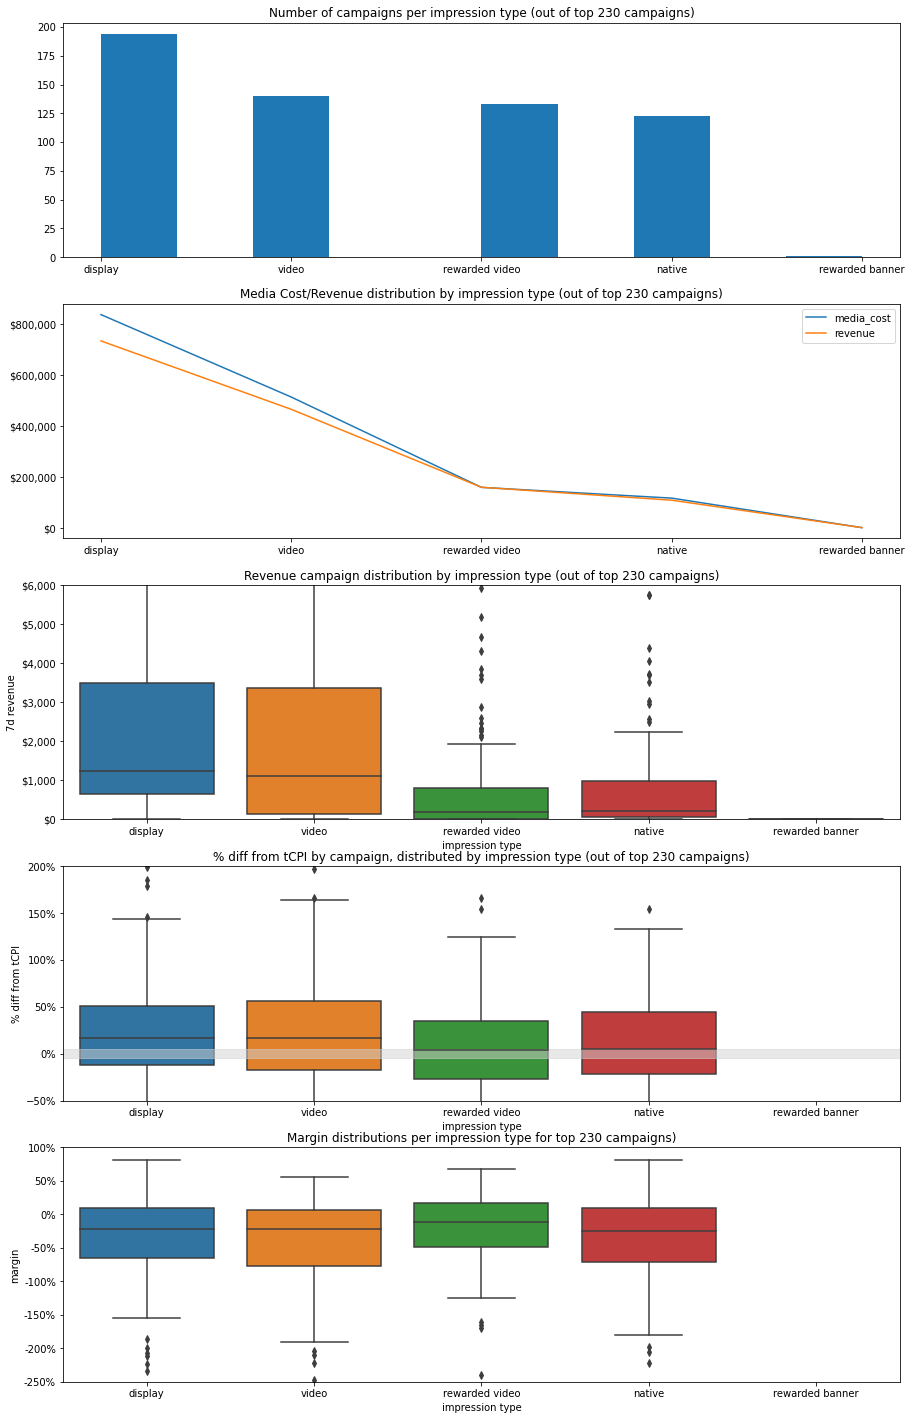

In [101]:
spend_bygrouping = pivot.groupby(i)['media_cost','spend'].sum()
col_order = pivot[i].iloc[:,0].unique().tolist()

fig, ax = plt.subplots(5,1,figsize = (15,25))
ax[0].hist(pivot[i])
ax[0].set_title(f'Number of campaigns per {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[1].plot(spend_bygrouping.loc[col_order])
ax[1].legend(['media_cost','revenue'])
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].set_title(f'Media Cost/Revenue distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'spend', data = pivot, ax = ax[2])
ax[2].set_ylim(0,6000)
ax[2].set_ylabel('7d revenue')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_title(f'Revenue campaign distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'diff_from_tcpi', data = pivot, ax = ax[3])
ax[3].set_ylim(-50,200)
ax[3].set_ylabel('% diff from tCPI')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].set_title(f'% diff from tCPI by campaign, distributed by {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[3].axhspan(-5,5, color = 'lightgrey', alpha = .5)
sns.boxplot(x = i[0], y = 'margin', data = pivot, ax = ax[4])
ax[4].set_ylim(-250,100)
ax[4].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}%'))
ax[4].set_title(f'Margin distributions per {i[0]} for top {all_campaign_ct} campaigns)')

In [102]:
filters = (df.date >= pd.to_datetime(end_dt)-datetime.timedelta(days=7))& (df.ssb_campaign_uuid.isin(all_campaign_list))
i = ['impression type','ad_type']
pivot = df[filters].pivot_table(values = ['cpi','auto_pilot_cpi_factor','media_cost','installs','spend'], index = i+['campaign_name','ssb_campaign_uuid'], 
                                aggfunc = {'cpi':np.mean,'auto_pilot_cpi_factor':np.mean,
                                          'media_cost':sum,'installs':sum,'spend':sum})
pivot['auto_pilot_cpi_factor'] = pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['margin'] = 100*(pivot.spend-pivot.media_cost)/pivot.spend
pivot['tCPI'] = pivot['cpi']*pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['eCPI'] = pivot['media_cost']/pivot['installs']
pivot['diff_from_tcpi'] = 100*(pivot.eCPI/pivot.tCPI) - 100
pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
pivot.sort_values('media_cost', ascending = False, inplace = True)
pivot.reset_index(inplace = True)
pivot['imp_ad_type'] = np.where(pivot['impression type'] == 'display', pivot['impression type']+' '+pivot.ad_type, pivot['impression type'])
i = ['imp_ad_type']
pivot.head(30)

impression type ad_type                                   campaign_name  \
0          display   inter        Position Mobile – Weather Home – US – UA   
1            video   inter        Position Mobile – Weather Home – US – UA   
2          display  banner       Pandora - Pandora - US - 4 -banner/native   
3            video   inter       Particle Media - News Break - US - VZW PR   
4            video   inter                Android-Grupo Coppel-Coppel-MX-2   
5          display  banner        Position Mobile – Weather Home – US – UA   
6            video   inter                    Android-Twitter-Twitter-PK-4   
7          display   inter                          FR Mobijeux IOS BT ALL   
8            video   inter                     Twitter - Twitter - BR - UA   
9          display   inter                     Twitter - Twitter - BR - UA   
10           video   inter          Android-Amply Media-Breaking News-US-2   
11         display  banner                    Pandora - Pandora - US - iOS   
12  rewarded video   inter        Position Mobile – Weather Home – US – UA   
13           video   inter      DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA   
14         display   inter       Particle Media - News Break - US - VZW PR   
15         display   inter                      Pandora - Pandora - US - 1   
16          native  banner       Pandora - Pandora - US - 4 -banner/native   
17           video   inter         Android-SmartNews Inc-SmartNews-US-VZ-2   
18         display   inter                      Pandora - Pandora - US - 2   
19           video   inter      Android-Magazine Luiza-Magazine Luiza-BR-2   
20  rewarded video   inter                Android-Grupo Coppel-Coppel-MX-2   
21           video   inter                      Pandora - Pandora - US - 2   
22         display   inter         SmartNews_Tracfone_SingleTap_All_CPI_NA   
23         display   inter  Particle Media - News Break - US - Tracfone PR   
24         display   inter      DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA   
25           video   inter                    Android-Twitter-Twitter-ID-4   
26           video   inter                                   Onnect_US_DRD   
27         display  banner                           TangleMaster3D_US_iOS   
28         display   inter                     44289-US-GT-iOS-Inte(T-Mob)   
29           video   inter       Particle Media - News Break - US - ATT PR   

                   ssb_campaign_uuid  auto_pilot_cpi_factor    cpi  installs  \
0   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     61216   
1   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     29104   
2   377f69bc9e2d613ee60d07d1df5897d5                   1.50   3.00     10592   
3   60afc4f294695ffe7ea525534f019d20                   1.20   3.60      8528   
4   ff5f6bfc2de6ff0dc959dc9300ed4f83                   0.90   0.50     97264   
5   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     14320   
6   962d52a1a1605f0086dcff2e9da3cada                   1.20   3.00      7184   
7   cd0efbabf9eb8408f17f78d551a304ea                   1.00  22.00      1200   
8   292906bbb71deaebb880439ce8c72995                   1.50   1.00     14208   
9   292906bbb71deaebb880439ce8c72995                   1.50   1.00     16272   
10  fb9d2fdb882ea110d77ab74ffc35730a                   1.00   0.75     28960   
11  8f6af55d3b890df1566e59c4bcf13d3c                   1.40   5.50      2992   
12  4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     10064   
13  3bf043901874bb0ef510dc88b8a764ad                   1.30   1.80      7808   
14  60afc4f294695ffe7ea525534f019d20                   1.20   3.60      4368   
15  30bc823acca34196010b05475c5d77ec                   1.00   2.30      8240   
16  377f69bc9e2d613ee60d07d1df5897d5                   1.50   3.00      4880   
17  099a5d47e9bf3796c1b9ca5c5f4bc264                   1.00   1.70      4208   
18  a60b75e69079fb3b46baf01c061b7a58                   1.20   2.

Text(0.5, 1.0, 'Margin distributions per imp_ad_type for top 230 campaigns)')

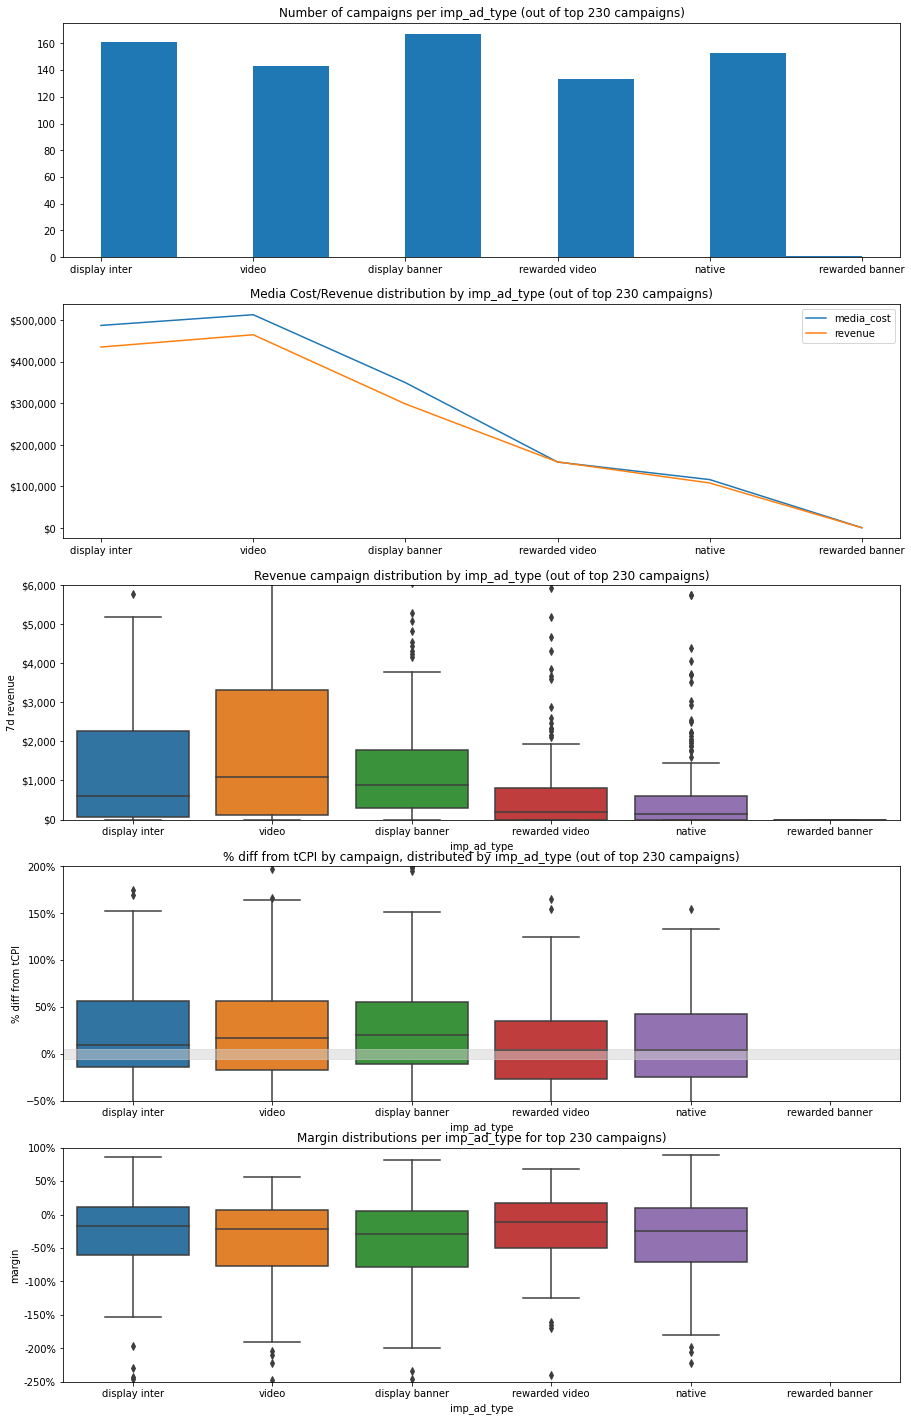

In [103]:
spend_bygrouping = pivot.groupby(i)['media_cost','spend'].sum()
col_order = pivot[i].iloc[:,0].unique().tolist()

fig, ax = plt.subplots(5,1,figsize = (15,25))
ax[0].hist(pivot[i])
ax[0].set_title(f'Number of campaigns per {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[1].plot(spend_bygrouping.loc[col_order])
ax[1].legend(['media_cost','revenue'])
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].set_title(f'Media Cost/Revenue distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'spend', data = pivot, ax = ax[2])
ax[2].set_ylim(0,6000)
ax[2].set_ylabel('7d revenue')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_title(f'Revenue campaign distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'diff_from_tcpi', data = pivot, ax = ax[3])
ax[3].set_ylim(-50,200)
ax[3].set_ylabel('% diff from tCPI')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].set_title(f'% diff from tCPI by campaign, distributed by {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[3].axhspan(-5,5, color = 'lightgrey', alpha = .5)
sns.boxplot(x = i[0], y = 'margin', data = pivot, ax = ax[4])
ax[4].set_ylim(-250,100)
ax[4].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}%'))
ax[4].set_title(f'Margin distributions per {i[0]} for top {all_campaign_ct} campaigns)')

Display banner has some of the lower performance in Q1, but video some of the lower for Q2.

In [104]:
filters = (df.date >= pd.to_datetime(end_dt)-datetime.timedelta(days=7)) & (df.ssb_campaign_uuid.isin(all_campaign_list))
i = ['exchange_name']
pivot = df[filters].pivot_table(values = ['cpi','auto_pilot_cpi_factor','media_cost','installs','spend'], index = i+['campaign_name','ssb_campaign_uuid'], 
                                aggfunc = {'cpi':np.mean,'auto_pilot_cpi_factor':np.mean,
                                          'media_cost':sum,'installs':sum,'spend':sum})
pivot['auto_pilot_cpi_factor'] = pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['margin'] = 100*(pivot.spend-pivot.media_cost)/pivot.spend
pivot['tCPI'] = pivot['cpi']*pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['eCPI'] = pivot['media_cost']/pivot['installs']
pivot['diff_from_tcpi'] = 100*(pivot.eCPI/pivot.tCPI) - 100
pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
pivot.sort_values('media_cost', ascending = False, inplace = True)
pivot.reset_index(inplace = True)
pivot.head(30)

exchange_name                                   campaign_name  \
0       AppLovin        Position Mobile – Weather Home – US – UA   
1          Fyber        Position Mobile – Weather Home – US – UA   
2       AppLovin                Android-Grupo Coppel-Coppel-MX-2   
3       AppLovin                     Twitter - Twitter - BR - UA   
4         InMobi        Position Mobile – Weather Home – US – UA   
5       AppLovin       Particle Media - News Break - US - VZW PR   
6       AppLovin                      Pandora - Pandora - US - 2   
7         InMobi                          FR Mobijeux IOS BT ALL   
8          MoPub        Position Mobile – Weather Home – US – UA   
9       AppLovin          Android-Amply Media-Breaking News-US-2   
10      AppLovin      Android-Magazine Luiza-Magazine Luiza-BR-2   
11         MoPub                    Android-Twitter-Twitter-PK-4   
12        InMobi       Particle Media - News Break - US - VZW PR   
13      AppLovin                      Pandora - Pandora - US - 1   
14      AppLovin         Android-SmartNews Inc-SmartNews-US-VZ-2   
15        InMobi      DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA   
16      AppLovin   Android-SmartNews Inc-SmartNews-US-Tracfone-2   
17         MoPub                     Twitter - Twitter - BR - UA   
18      AppLovin          SmartNews_Verizon_SingleTap_All_CPI_NA   
19      AppLovin       Particle Media - News Break - US - VZW UA   
20      AppLovin  Particle Media - News Break - US - Tracfone PR   
21        InMobi                     44289-US-GT-iOS-Inte(T-Mob)   
22         Fyber         SmartNews_Tracfone_SingleTap_All_CPI_NA   
23         Fyber                         Weedmaps-Weedmaps-US-UA   
24         MoPub       Pandora - Pandora - US - 4 -banner/native   
25         MoPub                    Android-Twitter-Twitter-ID-4   
26         Unity        Position Mobile – Weather Home – US – UA   
27      AppLovin              SmartNews_ATT_SingleTap_All_CPI_NA   
28      AppLovin           Position Mobile-Weather Home-US-2-SAD   
29         Fyber                     Twitter - Twitter - BR - UA   

                   ssb_campaign_uuid  auto_pilot_cpi_factor    cpi  installs  \
0   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     48416   
1   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     33072   
2   ff5f6bfc2de6ff0dc959dc9300ed4f83                   0.90   0.50    154624   
3   292906bbb71deaebb880439ce8c72995                   1.50   1.00     21232   
4   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     12320   
5   60afc4f294695ffe7ea525534f019d20                   1.20   3.60      8496   
6   a60b75e69079fb3b46baf01c061b7a58                   1.20   2.30      8400   
7   cd0efbabf9eb8408f17f78d551a304ea                   1.00  22.00      1168   
8   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50     11792   
9   fb9d2fdb882ea110d77ab74ffc35730a                   1.00   0.75     26816   
10  4602e704fb2f737aef26a2ddb7459a66                   1.85   0.44     42960   
11  962d52a1a1605f0086dcff2e9da3cada                   1.20   3.00      5648   
12  60afc4f294695ffe7ea525534f019d20                   1.20   3.60      3840   
13  30bc823acca34196010b05475c5d77ec                   1.00   2.30      9920   
14  099a5d47e9bf3796c1b9ca5c5f4bc264                   1.00   1.70      5504   
15  3bf043901874bb0ef510dc88b8a764ad                   1.30   1.80      6800   
16  d018489d8075c72fa12c6bf0e7f54fbb                   1.20   1.70      4784   
17  292906bbb71deaebb880439ce8c72995                   1.50   1.00      8736   
18  5fef83d15c5b811b424ed58aeb82d0a7                   1.50   1.70      9296   
19  c5534bbfcb4dccdd122f22da877a6f78                   1.00   3.00      2512   
20  50a1b5ac38354aa6f2b023e8e462c883                   1.40   1.20      7040   
21  01a919f4b50fe723e51d51b0c2d2509a                   1.00   8.00      1088   
22  d8be47c87ebd5047c552f92421103f1a                  

Text(0.5, 1.0, 'Margin distributions per exchange_name for top 230 campaigns)')

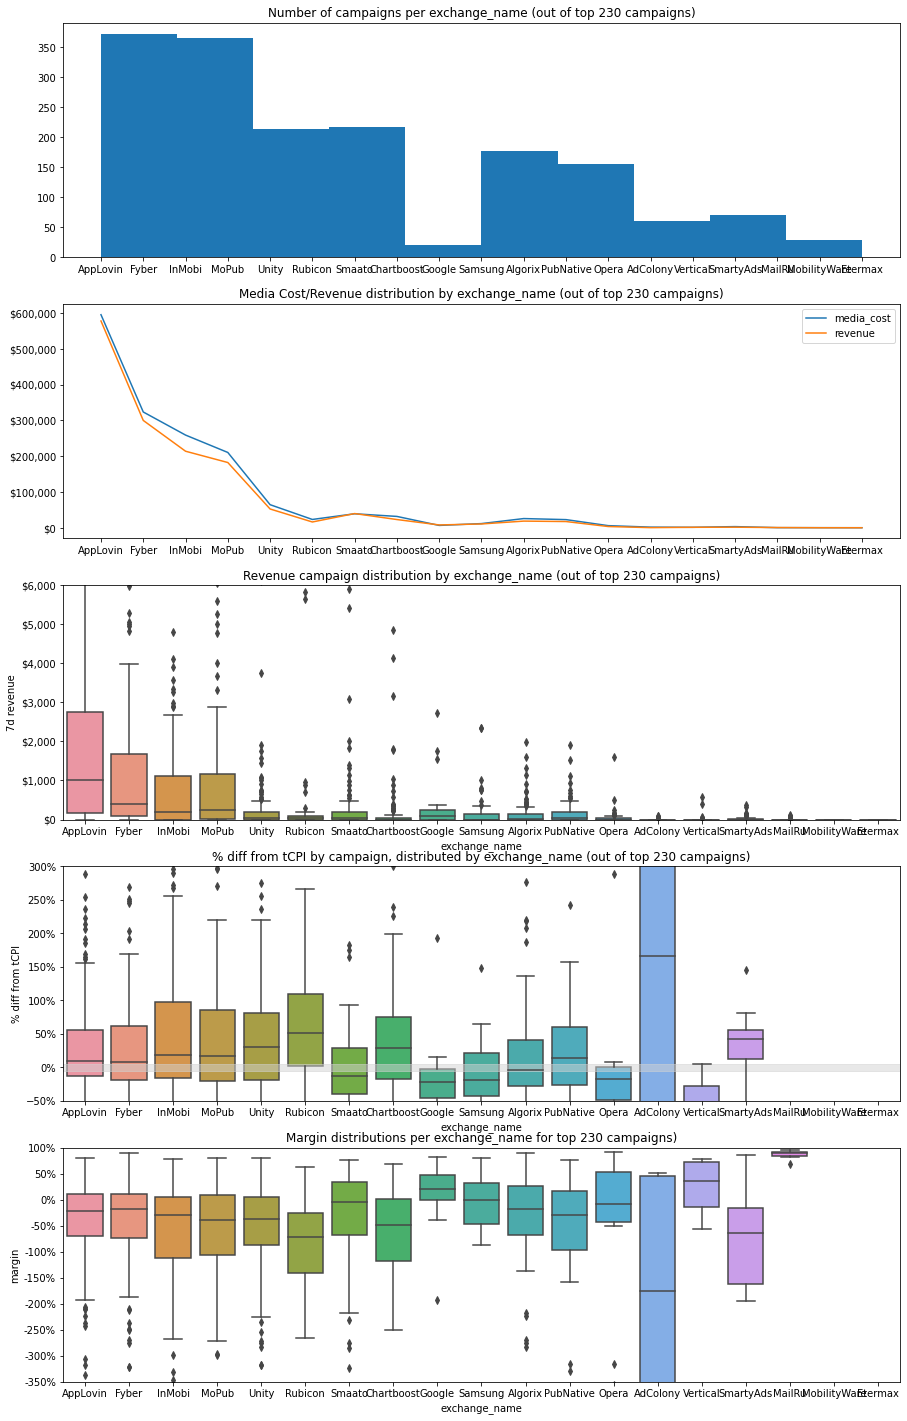

In [105]:
spend_bygrouping = pivot.groupby(i)['media_cost','spend'].sum()
col_order = pivot[i].iloc[:,0].unique().tolist()

fig, ax = plt.subplots(5,1,figsize = (15,25))
ax[0].hist(pivot[i])
ax[0].set_title(f'Number of campaigns per {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[1].plot(spend_bygrouping.loc[col_order])
ax[1].legend(['media_cost','revenue'])
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].set_title(f'Media Cost/Revenue distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'spend', data = pivot, ax = ax[2])
ax[2].set_ylim(0,6000)
ax[2].set_ylabel('7d revenue')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_title(f'Revenue campaign distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'diff_from_tcpi', data = pivot, ax = ax[3])
ax[3].set_ylim(-50,300)
ax[3].set_ylabel('% diff from tCPI')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].set_title(f'% diff from tCPI by campaign, distributed by {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[3].axhspan(-5,5, color = 'lightgrey', alpha = .5)
sns.boxplot(x = i[0], y = 'margin', data = pivot, ax = ax[4])
ax[4].set_ylim(-350,100)
ax[4].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}%'))
ax[4].set_title(f'Margin distributions per {i[0]} for top {all_campaign_ct} campaigns)')

In [106]:
filters = (df.date >= pd.to_datetime(end_dt)-datetime.timedelta(days=7)) & (df.ssb_campaign_uuid.isin(all_campaign_list))
i = ['model']
pivot = df[filters].pivot_table(values = ['cpi','auto_pilot_cpi_factor','media_cost','installs','spend'], index = i+['campaign_name','ssb_campaign_uuid'], 
                                aggfunc = {'cpi':np.mean,'auto_pilot_cpi_factor':np.mean,
                                          'media_cost':sum,'installs':sum,'spend':sum})
pivot['auto_pilot_cpi_factor'] = pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['margin'] = 100*(pivot.spend-pivot.media_cost)/pivot.spend
pivot['tCPI'] = pivot['cpi']*pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['eCPI'] = pivot['media_cost']/pivot['installs']
pivot['diff_from_tcpi'] = 100*(pivot.eCPI/pivot.tCPI) - 100
pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
pivot.sort_values('media_cost', ascending = False, inplace = True)
pivot.reset_index(inplace = True)
pivot.head(30)

model                                   campaign_name  \
0     ML        Position Mobile – Weather Home – US – UA   
1     ML       Particle Media - News Break - US - VZW PR   
2     ML                     Twitter - Twitter - BR - UA   
3     ML                Android-Grupo Coppel-Coppel-MX-2   
4     ML       Pandora - Pandora - US - 4 -banner/native   
5     ML                      Pandora - Pandora - US - 1   
6     ML                      Pandora - Pandora - US - 2   
7     ML                    Android-Twitter-Twitter-PK-4   
8     ML      DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA   
9     ML          Android-Amply Media-Breaking News-US-2   
10    ML          SmartNews_Verizon_SingleTap_All_CPI_NA   
11    ML         Android-SmartNews Inc-SmartNews-US-VZ-2   
12    ML  Particle Media - News Break - US - Tracfone PR   
13    AP                          FR Mobijeux IOS BT ALL   
14    ML   Android-SmartNews Inc-SmartNews-US-Tracfone-2   
15    ML                    Pandora - Pandora - US - iOS   
16    ML        Android-SmartNews Inc-SmartNews-US-ATT-2   
17    ML         SmartNews_Tracfone_SingleTap_All_CPI_NA   
18    ML              SmartNews_ATT_SingleTap_All_CPI_NA   
19    ML       Particle Media - News Break - US - VZW UA   
20    ML       Particle Media - News Break - US - ATT PR   
21    AP      Android-Magazine Luiza-Magazine Luiza-BR-2   
22    ML                    Android-Twitter-Twitter-ID-4   
23    ML                      Pandora - Pandora - US - 3   
24    ML           Position Mobile-Weather Home-US-2-SAD   
25    ML                   Android-WPromote-HBO Max-US-4   
26    ML                    Android-Twitter-Twitter-EG-2   
27    ML       Particle Media - News Break - US - ATT UA   
28    ML                Twitter - Twitter - BR - True GP   
29    ML    Particle Media – News Break – US – All – GP2   

                   ssb_campaign_uuid  auto_pilot_cpi_factor    cpi  installs  \
0   4c7f5d9964abdca5793b3d48f13fe6f9                   1.50   1.50    118576   
1   60afc4f294695ffe7ea525534f019d20                   1.20   3.60     18256   
2   292906bbb71deaebb880439ce8c72995                   1.50   1.00     38800   
3   ff5f6bfc2de6ff0dc959dc9300ed4f83                   0.90   0.50    204512   
4   377f69bc9e2d613ee60d07d1df5897d5                   1.50   3.00     15472   
5   30bc823acca34196010b05475c5d77ec                   1.00   2.30     21072   
6   a60b75e69079fb3b46baf01c061b7a58                   1.20   2.30     14384   
7   962d52a1a1605f0086dcff2e9da3cada                   1.20   3.00     11456   
8   3bf043901874bb0ef510dc88b8a764ad                   1.30   1.80     16432   
9   fb9d2fdb882ea110d77ab74ffc35730a                   1.00   0.75     42528   
10  5fef83d15c5b811b424ed58aeb82d0a7                   1.50   1.70     14928   
11  099a5d47e9bf3796c1b9ca5c5f4bc264                   1.00   1.70      7760   
12  50a1b5ac38354aa6f2b023e8e462c883                   1.40   1.20     14288   
13  cd0efbabf9eb8408f17f78d551a304ea                   1.00  22.00      1200   
14  d018489d8075c72fa12c6bf0e7f54fbb                   1.20   1.70      9360   
15  8f6af55d3b890df1566e59c4bcf13d3c                   1.40   5.50      3648   
16  460c77fda3ba6cdf651311f5eedb7187                   1.20   1.70      9152   
17  d8be47c87ebd5047c552f92421103f1a                   1.50   1.70     12432   
18  33bff90d655b976e9399f1d0b0463d22                   1.50   1.70     14560   
19  c5534bbfcb4dccdd122f22da877a6f78                   1.00   3.00      4064   
20  b291b1c34d27bb722c2a3cd95748e5f0                   1.00   2.25      8512   
21  4602e704fb2f737aef26a2ddb7459a66                   1.85   0.44     51872   
22  e8fd14220c0331282ea593f073fe10c7                   1.20   2.00      4112   
23  26ae46e908d03fbe20c01f7fd804a788                   1.20   2.30      8464   
24  99c072bcbce58e7ef79a19d917ef8991                   1.50   1.50      6352   
25  fd7d50a6a6412fd090e43abe3dbc774e                   1.20   

Text(0.5, 1.0, 'Margin distributions per model for top 230 campaigns)')

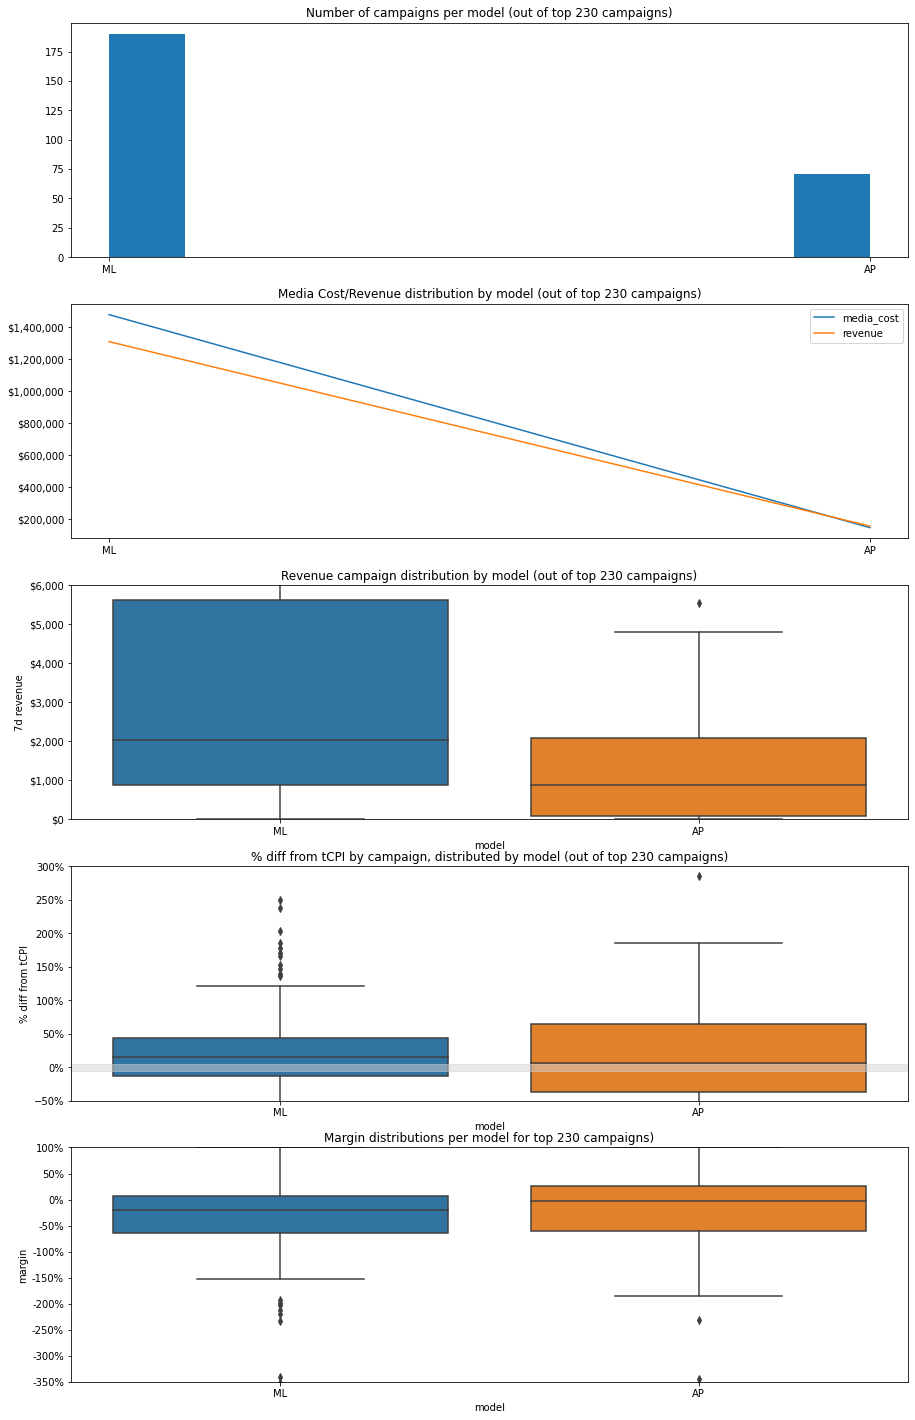

In [107]:
spend_bygrouping = pivot.groupby(i)['media_cost','spend'].sum()
col_order = pivot[i].iloc[:,0].unique().tolist()

fig, ax = plt.subplots(5,1,figsize = (15,25))
ax[0].hist(pivot[i])
ax[0].set_title(f'Number of campaigns per {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[1].plot(spend_bygrouping.loc[col_order])
ax[1].legend(['media_cost','revenue'])
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].set_title(f'Media Cost/Revenue distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'spend', data = pivot, ax = ax[2])
ax[2].set_ylim(0,6000)
ax[2].set_ylabel('7d revenue')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_title(f'Revenue campaign distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'diff_from_tcpi', data = pivot, ax = ax[3])
ax[3].set_ylim(-50,300)
ax[3].set_ylabel('% diff from tCPI')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].set_title(f'% diff from tCPI by campaign, distributed by {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[3].axhspan(-5,5, color = 'lightgrey', alpha = .5)
sns.boxplot(x = i[0], y = 'margin', data = pivot, ax = ax[4])
ax[4].set_ylim(-350,100)
ax[4].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}%'))
ax[4].set_title(f'Margin distributions per {i[0]} for top {all_campaign_ct} campaigns)')

In [108]:
filters = (df.date >= pd.to_datetime(end_dt)-datetime.timedelta(days=7)) & (df.ssb_campaign_uuid.isin(all_campaign_list))
i = ['platform','osv_major']
pivot = df[filters].pivot_table(values = ['cpi','auto_pilot_cpi_factor','media_cost','installs','spend'], index = i+['campaign_name','ssb_campaign_uuid'], 
                                aggfunc = {'cpi':np.mean,'auto_pilot_cpi_factor':np.mean,
                                          'media_cost':sum,'installs':sum,'spend':sum})
pivot['auto_pilot_cpi_factor'] = pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['margin'] = 100*(pivot.spend-pivot.media_cost)/pivot.spend
pivot['tCPI'] = pivot['cpi']*pivot['auto_pilot_cpi_factor'].fillna(1)
pivot['eCPI'] = pivot['media_cost']/pivot['installs']
pivot['diff_from_tcpi'] = 100*(pivot.eCPI/pivot.tCPI) - 100
pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
pivot.sort_values('media_cost', ascending = False, inplace = True)
pivot.reset_index(inplace = True)
pivot['osv_major'] = pivot['osv_major'].astype(int, errors = 'ignore')
pivot['platform_osv'] = np.where(pivot.platform == 1, 'Android-'+pivot.osv_major.astype(str), 'iOS-'+pivot.osv_major.astype(str))
i = ['platform_osv']
pivot.head(30)

KeyError: 'osv_major'

In [ ]:
i = ['osv_major']
pivot = pivot.loc[(pivot.platform == 1) & (pivot.osv_major.isin(list(range(5,15))))]
spend_bygrouping = pivot.groupby(i)['media_cost','spend'].sum()

fig, ax = plt.subplots(5,1,figsize = (15,25))
ax[0].hist(pivot[i])
ax[0].set_title(f'Number of campaigns per {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[1].plot(spend_bygrouping)
ax[1].legend(['media_cost','revenue'])
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].set_title(f'Media Cost/Revenue distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'spend', data = pivot, ax = ax[2])
ax[2].set_ylim(0,6000)
ax[2].set_ylabel('7d revenue')
ax[2].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[2].set_title(f'Revenue campaign distribution by {i[0]} (out of top {all_campaign_ct} campaigns)')
sns.boxplot(x = i[0], y = 'diff_from_tcpi', data = pivot, ax = ax[3])
ax[3].set_ylim(-50,300)
ax[3].set_ylabel('% diff from tCPI')
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].set_title(f'% diff from tCPI by campaign, distributed by {i[0]} (out of top {all_campaign_ct} campaigns)')
ax[3].axhspan(-5,5, color = 'lightgrey', alpha = .5)
sns.boxplot(x = i[0], y = 'margin', data = pivot, ax = ax[4])
ax[4].set_ylim(-350,100)
ax[4].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}%'))
ax[4].set_title(f'Margin distributions per {i[0]} for top {all_campaign_ct} campaigns)')

In [ ]:
df.columns.tolist()

# continuing searching through params for margin

In [ ]:
i = ['iab_category']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['store_category']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['dt_enabled']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['dt_enabled','ssb_buyer_id']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,8), sharex=True, sharey=True)
ax[0].set_xlim(0,100000)
ax[0].set_ylim(-500,200)
sns.scatterplot(x = 'media_cost', y = 'margin', data = format_pivot.loc[(format_pivot.index.get_level_values(0)==True) & (format_pivot.media_cost_sov>.1)], ax = ax[0])
ax[0].set_title('dt_enabled, margin x media cost by buyer')
sns.scatterplot(x = 'media_cost', y = 'margin', data = format_pivot.loc[(format_pivot.index.get_level_values(0)==False) & (format_pivot.media_cost_sov>.1)], ax = ax[1])
ax[1].set_title('not dt_enabled, margin x media cost by buyer')
sns.scatterplot(x = 'media_cost', y = 'margin', data = format_pivot.loc[(format_pivot.index.get_level_values(0)==-1) & (format_pivot.media_cost_sov>.1)], ax = ax[2])
ax[2].set_title('null dt_enabled, margin x media cost by buyer')


In [ ]:
i = ['dt_enabled','ssb_buyer_id','campaign_name']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,8), sharex=True, sharey=True)
ax[0].set_xlim(0,100000)
ax[0].set_ylim(-500,200)
sns.scatterplot(x = 'media_cost', y = 'margin', data = format_pivot.loc[(format_pivot.index.get_level_values(0)==True) & (format_pivot.media_cost_sov>.01)], ax = ax[0])
ax[0].set_title('dt_enabled, margin x media cost by buyer')
sns.scatterplot(x = 'media_cost', y = 'margin', data = format_pivot.loc[(format_pivot.index.get_level_values(0)==False) & (format_pivot.media_cost_sov>.01)], ax = ax[1])
ax[1].set_title('not dt_enabled, margin x media cost by buyer')
sns.scatterplot(x = 'media_cost', y = 'margin', data = format_pivot.loc[(format_pivot.index.get_level_values(0)==-1) & (format_pivot.media_cost_sov>.01)], ax = ax[2])
ax[2].set_title('null dt_enabled, margin x media cost by buyer')


In [ ]:
i = ['dt_enabled','experience_type']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

Looks like dt_enabled has to do with audiences, since experience 4 is all False but the other experiences are True. This is a trend we already knew about..

In [ ]:
i = ['impression_pixel_url']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['user_defined_optimization_type']

if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['enable_s2s_click']
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['enable_imp_dedup']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
df['osv_major'] = df['os_version_text'].str.split('.').str[0].astype(int, errors = 'ignore')
df[['osv_major','os_version_text']].value_counts().head(30)

In [ ]:
i = ['platform','osv_major']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[~df.bug].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot = format_pivot[format_pivot.media_cost_sov>.1]
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
android_byosv = format_pivot[format_pivot.index.get_level_values(0) == 1].droplevel(0)
android_byosv.index = android_byosv.index.astype(int)

fig, ax = plt.subplots(3,1,figsize = (10,13))
android_byosv.sort_index(inplace = True)

ax[0].plot(android_byosv.loc[:, ['spend_sov','media_cost_sov']])
# ax[0].set_xlim(5,12)
ax[0].legend(['spend_sov','media_cost_sov'])
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_title('Android')
ax[1].plot(android_byosv.loc[:, ['margin']])
ax[1].set_ylim(-100,0)
ax[1].legend(['margin'])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].plot(android_byosv.loc[:, ['ipm','cpm']])
# ax[2].set_xlim(5,12)
ax[2].legend(['ipm','cpm'])

While there is only 1-2% of overall margin to be extracted by optimizing os version overall, on the individual campaign level we may see better gains.

# Troubleshooing drop on 7/27

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week

i = ['week','date']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
pivot = df[df.date>=datetime.datetime(2021,7,19)].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
# format_pivot.sort_values('spend', ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','sponsored_bnd_name']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','deal_id']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','impression type','ad_type']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','hosting_bnd_name','impression type','ad_size']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','auto_pilot_cpi_factor']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
format_pivot['profit'] = format_pivot['spend'] - format_pivot['media_cost']
fig, ax = plt.subplots(3,1,figsize = (10,15), sharex = True)
format_pivot.loc[(format_pivot.index.get_level_values(0) == 29) & (format_pivot.media_cost_sov>.5), 'margin'].sort_index().droplevel(0).plot(ax=ax[0])
format_pivot.loc[(format_pivot.index.get_level_values(0) == 30) & (format_pivot.media_cost_sov>.5), 'margin'].sort_index().droplevel(0).plot(ax=ax[0])
format_pivot.loc[(format_pivot.index.get_level_values(0) == 29) & (format_pivot.media_cost_sov>.5), 'profit'].sort_index().droplevel(0).plot(ax=ax[1])
format_pivot.loc[(format_pivot.index.get_level_values(0) == 30) & (format_pivot.media_cost_sov>.5), 'profit'].sort_index().droplevel(0).plot(ax=ax[1])
df_offers_joined[['auto_pilot_cpi_factor']].hist(ax = ax[2], bins = 20)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].legend(['week 29','week 30'])
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[0].set_xlim(0,4)
ax[1].set_xlim(0,4)
ax[0].set_title('Comparison of Margin % for week 29 vs. 30')
ax[1].set_title('Comparison of Profit $ for week 29 vs. 30')

In [ ]:
i = ['week','sponsored_bnd_name','campaign_name']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30]) & (df.auto_pilot_cpi_factor == 1.5)
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','date','sponsored_bnd_name','campaign_name']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])  & (df.campaign_name == 'Position Mobile – Weather Home – US – UA')
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
# format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','campaign_name','exchange_name','hosting_bnd_name','ad_size']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])  & (df.campaign_name == 'Position Mobile – Weather Home – US – UA')
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','date','sponsored_bnd_name','campaign_name']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = df.week.isin([29,30])  & (df.campaign_name == 'Position Mobile – Weather Home – US – UA')
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
# format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','impression type','ad_type']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = (df.date>=datetime.datetime(2021,7,19)) & (df.campaign_name == 'Android-SmartNews Inc-SmartNews-US-ATT-3')
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['hosting_bnd_name','impression type','ad_size','week','date']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = (df.date>=datetime.datetime(2021,7,19)) & (df.campaign_name == 'Android-SmartNews Inc-SmartNews-US-ATT-3') & (df['impression type'] == 'video') & (df.ad_type == 'inter') & (df.hosting_bnd_name == 'Solitaire')
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
# format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')

In [ ]:
i = ['week','experience_type']
if ~isinstance(i,list):
    i = list(i)
if len(i) > 1:
    agg_group = i[0]
else:
    agg_group = 0
    
filters = (df.date>=datetime.datetime(2021,7,19)) & (df.auto_pilot_cpi_factor == 1.5)
pivot = df[filters].fillna(-1).pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i, aggfunc = np.sum)
format_pivot = calc_metrics(pivot, agg_group)
format_pivot.replace([np.inf, -np.inf], np.nan, inplace = True)
format_pivot['total_media_cost'] = format_pivot.media_cost.groupby(i[1:]).transform(sum)
format_pivot.sort_values(['total_media_cost','week'], ascending = False, inplace = True)
format_pivot.head(40).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','margin','media_cost_sov','spend_sov']).applymap(lambda x:'color:white;background-color:white' if pd.isnull(x) else '')